In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
train_df = pd.read_csv("./AIFrenz_Season1_dataset/train.csv")
#train_df.drop(columns=["X14","X16","X19"], inplace=True)
print(train_df.shape)
train_df.head()

(4752, 60)


,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,...,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,...,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,...,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,...,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,...,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN


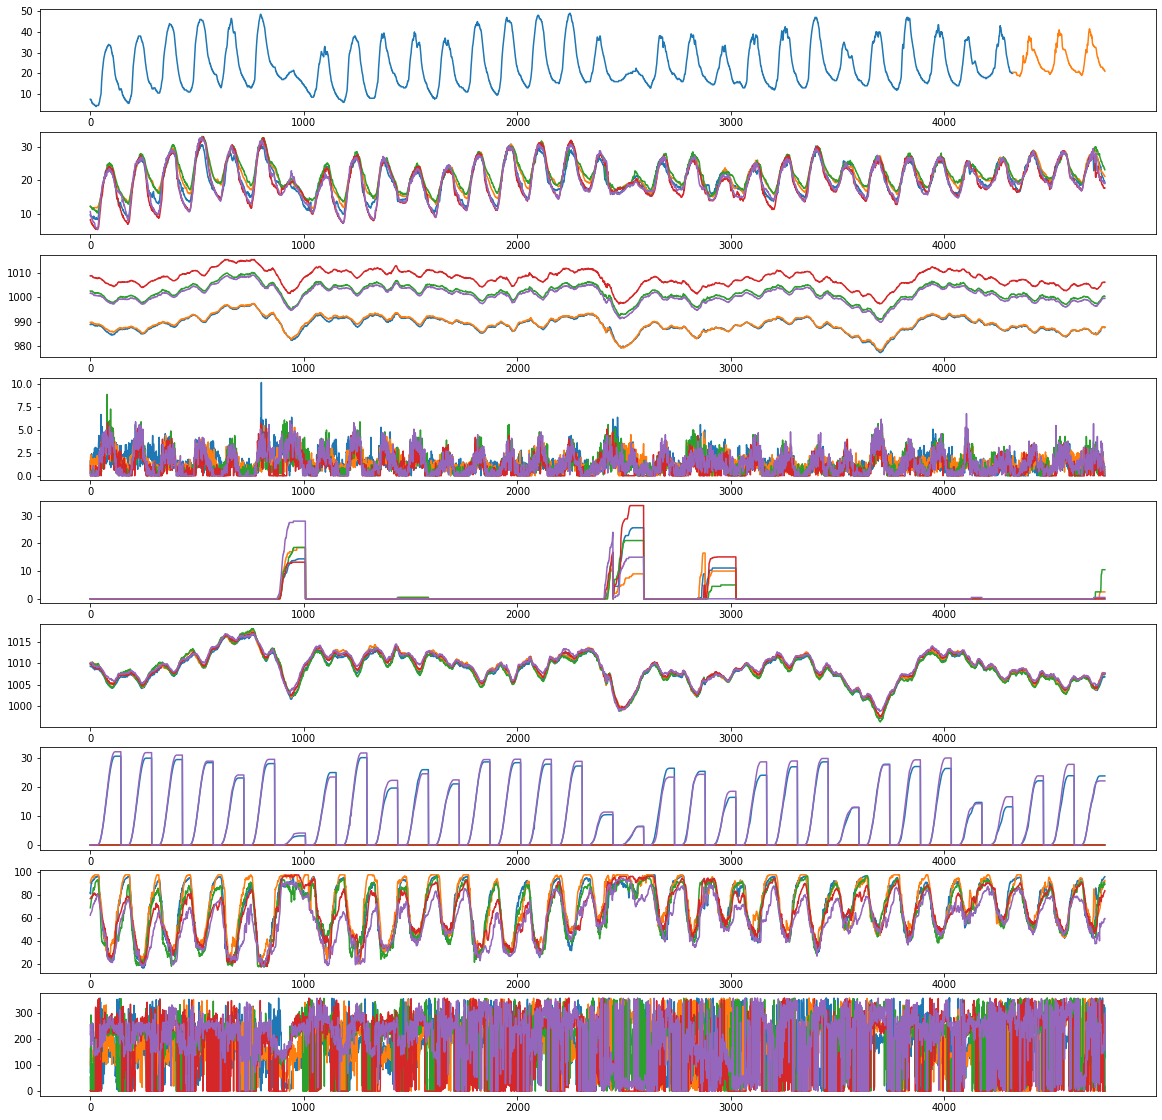

In [3]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(9,1,1)
ax2 = fig.add_subplot(9,1,2)
ax3 = fig.add_subplot(9,1,3)
ax4 = fig.add_subplot(9,1,4)
ax5 = fig.add_subplot(9,1,5)
ax6 = fig.add_subplot(9,1,6)
ax7 = fig.add_subplot(9,1,7)
ax8 = fig.add_subplot(9,1,8)
ax9 = fig.add_subplot(9,1,9)

ax1.plot(range(4320), np.array(train_df["Y10"])[:4320])
ax1.plot(range(4320,4752), np.array(train_df["Y18"])[4320:4752])
for col in ["X00","X07","X28","X31","X32"]:
    ax2.plot(np.array(train_df[col]))
for col in ["X01","X06","X22","X27","X29"]:
    ax3.plot(np.array(train_df[col]))
for col in ["X02","X03","X18","X24","X26"]:
    ax4.plot(np.array(train_df[col]))
for col in ["X04","X10","X21","X36","X39"]:
    ax5.plot(np.array(train_df[col]))
for col in ["X05","X08","X09","X23","X33"]:
    ax6.plot(np.array(train_df[col]))
for col in ["X11","X14","X16","X19","X34"]:
    ax7.plot(np.array(train_df[col]))
for col in ["X12","X20","X30","X37","X38"]:
    ax8.plot(np.array(train_df[col]))
for col in ["X13","X15","X17","X25","X35"]:
    ax9.plot(np.array(train_df[col]))
plt.show()

In [3]:
x_parts = np.array(train_df[train_df.columns[1:38]].iloc[:-432], dtype=np.float32)
x_18parts = np.array(train_df[train_df.columns[1:38]].iloc[-432:], dtype=np.float32)
y_parts = np.array(train_df[train_df.columns[38:-1]].iloc[:-432], dtype=np.float32)
y_18parts = np.array(train_df[train_df.columns[-1:]].iloc[-432:], dtype=np.float32)
print(x_parts.shape, x_18parts.shape, y_parts.shape, y_18parts.shape)

(4320, 37) (432, 37) (4320, 18) (432, 1)


In [4]:
def return_module(input_tensor, layer_batch):
    x = tf.keras.layers.Dense(layer_batch[0])(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    for num in layer_batch[1:]:
        x = tf.keras.layers.Dense(num)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(1)(x)
    return x
        

def return_model():
    input_tens = tf.keras.Input(shape=(37))
    x0 = return_module(input_tensor=input_tens, layer_batch=[16,16,16])
    #x = tf.keras.layers.concatenate(inputs=[x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17])
    model = tf.keras.Model(inputs=input_tens, outputs=x0)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=["mae"])
    print(model.summary())
    return model

In [5]:
result_col_list=[]
min_loss = 100
result_col={}
for col_idx in range(y_parts.shape[1]):
    train_x_parts = x_parts[:-144*5]
    test_x_parts = x_parts[-144*5:]
    train_y_parts = y_parts[:-144*5,col_idx]
    test_y_parts = y_parts[-144*5:,col_idx]
    
    train_x_parts_min = train_x_parts.min(axis=0)
    train_x_parts_max = train_x_parts.max(axis=0)
    train_x_parts_range = train_x_parts_max-train_x_parts_min
    train_x_parts_range = np.where(train_x_parts_range==0,1,train_x_parts_range)
    
    train_x_parts = (train_x_parts-train_x_parts_min)/train_x_parts_range
    test_x_parts = (test_x_parts-train_x_parts_min)/train_x_parts_range

    model = return_model()
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100)
    model.fit(train_x_parts, train_y_parts, epochs=500, batch_size=128, validation_data=(test_x_parts,test_y_parts))
    
    test_pred = model.predict(test_x_parts)
    test_mse = mean_squared_error(test_y_parts,test_pred)
    print(test_mse)
    
    x_18parts_reg = (x_18parts-train_x_parts_min)/train_x_parts_range
    pred_need = model.predict(x_18parts_reg)
    
    fin_mse = mean_squared_error(y_18parts,pred_need)
    print(fin_mse)
    
    if (fin_mse<2)&(test_mse<2):
        result_col_list.append(col_idx)
    if min_loss>fin_mse:
        min_loss=fin_mse
        min_idx = col_idx
    result_col[col_idx]=[test_mse,fin_mse]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 37)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                608       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
re_lu (ReLU)                 (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16)                0     

3600/3600 [==============================] - 0s 13us/sample - loss: 0.5116 - mae: 0.5617 - val_loss: 0.6643 - val_mae: 0.6810
Epoch 105/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.5301 - mae: 0.5681 - val_loss: 0.5566 - val_mae: 0.6178
Epoch 106/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4636 - mae: 0.5391 - val_loss: 0.5356 - val_mae: 0.5953
Epoch 107/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.6499 - mae: 0.6063 - val_loss: 0.5108 - val_mae: 0.5669
Epoch 108/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.5808 - mae: 0.6043 - val_loss: 0.4804 - val_mae: 0.5699
Epoch 109/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.5035 - mae: 0.5525 - val_loss: 0.5289 - val_mae: 0.5851
Epoch 110/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.4629 - mae: 0.5363 - val_loss: 0.4762 - val_mae: 0.5504
Epoch 111/500
3600/3600 [=========

3600/3600 [==============================] - 0s 13us/sample - loss: 0.2816 - mae: 0.4202 - val_loss: 0.3408 - val_mae: 0.4635
Epoch 221/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.3340 - mae: 0.4538 - val_loss: 0.3451 - val_mae: 0.4575
Epoch 222/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.2901 - mae: 0.4228 - val_loss: 0.3753 - val_mae: 0.4832
Epoch 223/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.4066 - mae: 0.4893 - val_loss: 0.3945 - val_mae: 0.5108
Epoch 224/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.3212 - mae: 0.4443 - val_loss: 0.4380 - val_mae: 0.5529
Epoch 225/500
3600/3600 [==============================] - 0s 12us/sample - loss: 0.4187 - mae: 0.4953 - val_loss: 0.3519 - val_mae: 0.4509
Epoch 226/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.3028 - mae: 0.4305 - val_loss: 0.3923 - val_mae: 0.5080
Epoch 227/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 0.2533 - mae: 0.3945 - val_loss: 0.3450 - val_mae: 0.4484
Epoch 337/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.2904 - mae: 0.4098 - val_loss: 0.3688 - val_mae: 0.4648
Epoch 338/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.2904 - mae: 0.4226 - val_loss: 0.3459 - val_mae: 0.4472
Epoch 339/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.2341 - mae: 0.3802 - val_loss: 0.3265 - val_mae: 0.4475
Epoch 340/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.2972 - mae: 0.4336 - val_loss: 0.3299 - val_mae: 0.4515
Epoch 341/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.2890 - mae: 0.4206 - val_loss: 0.3257 - val_mae: 0.4427
Epoch 342/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.2522 - mae: 0.4023 - val_loss: 0.3722 - val_mae: 0.4747
Epoch 343/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 0.2237 - mae: 0.3727 - val_loss: 0.2518 - val_mae: 0.3976
Epoch 453/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.2427 - mae: 0.3856 - val_loss: 0.2934 - val_mae: 0.4259
Epoch 454/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.2391 - mae: 0.3824 - val_loss: 0.3801 - val_mae: 0.4999
Epoch 455/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.2092 - mae: 0.3571 - val_loss: 0.2965 - val_mae: 0.4265
Epoch 456/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.3092 - mae: 0.4243 - val_loss: 0.2948 - val_mae: 0.4280
Epoch 457/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.2484 - mae: 0.3925 - val_loss: 0.4117 - val_mae: 0.5320
Epoch 458/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.2762 - mae: 0.4129 - val_loss: 0.3300 - val_mae: 0.4483
Epoch 459/500
3600/3600 [=========

Train on 3600 samples, validate on 720 samples
Epoch 1/500
3600/3600 [==============================] - 1s 173us/sample - loss: 599.1576 - mae: 23.3608 - val_loss: 626.2234 - val_mae: 24.2676
Epoch 2/500
3600/3600 [==============================] - 0s 15us/sample - loss: 572.0574 - mae: 22.9861 - val_loss: 610.9048 - val_mae: 24.0059
Epoch 3/500
3600/3600 [==============================] - 0s 15us/sample - loss: 548.4822 - mae: 22.5862 - val_loss: 591.2476 - val_mae: 23.6833
Epoch 4/500
3600/3600 [==============================] - 0s 15us/sample - loss: 525.1019 - mae: 22.1492 - val_loss: 564.7333 - val_mae: 23.2136
Epoch 5/500
3600/3600 [==============================] - 0s 13us/sample - loss: 501.4658 - mae: 21.6899 - val_loss: 535.5775 - val_mae: 22.6777
Epoch 6/500
3600/3600 [==============================] - 0s 14us/sample - loss: 478.7804 - mae: 21.2321 - val_loss: 503.6350 - val_mae: 22.0636
Epoch 7/500
3600/3600 [==============================] - 0s 14us/sample - loss: 455.3612

Epoch 117/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.0940 - mae: 0.8191 - val_loss: 2.2296 - val_mae: 1.1693
Epoch 118/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.3925 - mae: 0.8876 - val_loss: 2.2667 - val_mae: 1.1657
Epoch 119/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.2127 - mae: 0.8584 - val_loss: 2.3310 - val_mae: 1.1383
Epoch 120/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1748 - mae: 0.8447 - val_loss: 2.1729 - val_mae: 1.1343
Epoch 121/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.2187 - mae: 0.8485 - val_loss: 2.0777 - val_mae: 1.1108
Epoch 122/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.3909 - mae: 0.9131 - val_loss: 2.2805 - val_mae: 1.1789
Epoch 123/500
3600/3600 [==============================] - 0s 12us/sample - loss: 1.4107 - mae: 0.9391 - val_loss: 2.2298 - val_mae: 1.1583
Epoch 124/500
3600/3

3600/3600 [==============================] - 0s 14us/sample - loss: 0.8427 - mae: 0.7124 - val_loss: 2.0850 - val_mae: 1.0994
Epoch 234/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8726 - mae: 0.7284 - val_loss: 1.9546 - val_mae: 1.0144
Epoch 235/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8388 - mae: 0.7186 - val_loss: 2.1875 - val_mae: 1.1234
Epoch 236/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8033 - mae: 0.6990 - val_loss: 2.1901 - val_mae: 1.1382
Epoch 237/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8633 - mae: 0.7295 - val_loss: 2.1989 - val_mae: 1.1213
Epoch 238/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8605 - mae: 0.7007 - val_loss: 2.2133 - val_mae: 1.1288
Epoch 239/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.0111 - mae: 0.7945 - val_loss: 2.3831 - val_mae: 1.1448
Epoch 240/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 0.6987 - mae: 0.6551 - val_loss: 2.1454 - val_mae: 1.0895
Epoch 350/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8122 - mae: 0.6893 - val_loss: 2.0939 - val_mae: 1.0768
Epoch 351/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7689 - mae: 0.6863 - val_loss: 2.1933 - val_mae: 1.1225
Epoch 352/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7838 - mae: 0.7038 - val_loss: 2.1602 - val_mae: 1.1184
Epoch 353/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8145 - mae: 0.7026 - val_loss: 2.1412 - val_mae: 1.1211
Epoch 354/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.7069 - mae: 0.6490 - val_loss: 1.9974 - val_mae: 1.0494
Epoch 355/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.7281 - mae: 0.6744 - val_loss: 2.1904 - val_mae: 1.1258
Epoch 356/500
3600/3600 [=========

3600/3600 [==============================] - 0s 13us/sample - loss: 0.6874 - mae: 0.6471 - val_loss: 2.1511 - val_mae: 1.0869
Epoch 466/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.6334 - mae: 0.6208 - val_loss: 2.4886 - val_mae: 1.2103
Epoch 467/500
3600/3600 [==============================] - 0s 15us/sample - loss: 0.7399 - mae: 0.6733 - val_loss: 2.6433 - val_mae: 1.2377
Epoch 468/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.6648 - mae: 0.6434 - val_loss: 2.1174 - val_mae: 1.0711
Epoch 469/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.6715 - mae: 0.6457 - val_loss: 2.4799 - val_mae: 1.2289
Epoch 470/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8377 - mae: 0.7226 - val_loss: 2.4299 - val_mae: 1.1963
Epoch 471/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.6887 - mae: 0.6458 - val_loss: 2.3919 - val_mae: 1.1693
Epoch 472/500
3600/3600 [=========

Epoch 10/500
3600/3600 [==============================] - 0s 14us/sample - loss: 402.7986 - mae: 19.6359 - val_loss: 370.9265 - val_mae: 19.0504
Epoch 11/500
3600/3600 [==============================] - 0s 15us/sample - loss: 379.3122 - mae: 19.0775 - val_loss: 341.0431 - val_mae: 18.2781
Epoch 12/500
3600/3600 [==============================] - 0s 14us/sample - loss: 356.0673 - mae: 18.5035 - val_loss: 311.1549 - val_mae: 17.4658
Epoch 13/500
3600/3600 [==============================] - 0s 14us/sample - loss: 333.0796 - mae: 17.9078 - val_loss: 295.8831 - val_mae: 17.0384
Epoch 14/500
3600/3600 [==============================] - 0s 14us/sample - loss: 309.9714 - mae: 17.2838 - val_loss: 282.4789 - val_mae: 16.6500
Epoch 15/500
3600/3600 [==============================] - 0s 14us/sample - loss: 286.6174 - mae: 16.6439 - val_loss: 256.6499 - val_mae: 15.8435
Epoch 16/500
3600/3600 [==============================] - 0s 14us/sample - loss: 264.3236 - mae: 15.9847 - val_loss: 235.6932 - va

Epoch 127/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.1594 - mae: 0.8314 - val_loss: 2.7110 - val_mae: 1.1129
Epoch 128/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.0412 - mae: 0.8054 - val_loss: 2.4262 - val_mae: 1.0658
Epoch 129/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.0194 - mae: 0.7984 - val_loss: 2.6681 - val_mae: 1.1567
Epoch 130/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.9596 - mae: 0.7709 - val_loss: 2.6075 - val_mae: 1.1634
Epoch 131/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.0614 - mae: 0.8109 - val_loss: 1.9207 - val_mae: 0.9309
Epoch 132/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.1169 - mae: 0.8305 - val_loss: 1.9409 - val_mae: 0.9873
Epoch 133/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.9324 - mae: 0.7549 - val_loss: 2.9843 - val_mae: 1.2458
Epoch 134/500
3600/3

3600/3600 [==============================] - 0s 13us/sample - loss: 0.7331 - mae: 0.6672 - val_loss: 1.5953 - val_mae: 0.8995
Epoch 244/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.7245 - mae: 0.6642 - val_loss: 1.8783 - val_mae: 0.9922
Epoch 245/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8119 - mae: 0.7010 - val_loss: 1.5105 - val_mae: 0.8432
Epoch 246/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.6923 - mae: 0.6548 - val_loss: 1.7473 - val_mae: 0.9532
Epoch 247/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8977 - mae: 0.7318 - val_loss: 2.0528 - val_mae: 0.9857
Epoch 248/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8041 - mae: 0.6850 - val_loss: 2.2866 - val_mae: 1.0761
Epoch 249/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7107 - mae: 0.6596 - val_loss: 1.9663 - val_mae: 0.9518
Epoch 250/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 0.6479 - mae: 0.6266 - val_loss: 1.9875 - val_mae: 1.0186
Epoch 360/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.6728 - mae: 0.6445 - val_loss: 1.7222 - val_mae: 0.9549
Epoch 361/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.6640 - mae: 0.6179 - val_loss: 1.5003 - val_mae: 0.8930
Epoch 362/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.7310 - mae: 0.6676 - val_loss: 1.4802 - val_mae: 0.8925
Epoch 363/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.6769 - mae: 0.6344 - val_loss: 1.3468 - val_mae: 0.8232
Epoch 364/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.7033 - mae: 0.6283 - val_loss: 1.4080 - val_mae: 0.8488
Epoch 365/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8066 - mae: 0.7024 - val_loss: 1.5553 - val_mae: 0.9012
Epoch 366/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 0.5679 - mae: 0.5910 - val_loss: 1.2578 - val_mae: 0.8535
Epoch 476/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.6080 - mae: 0.6172 - val_loss: 1.4187 - val_mae: 0.8608
Epoch 477/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.5852 - mae: 0.5967 - val_loss: 1.4760 - val_mae: 0.8767
Epoch 478/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.5900 - mae: 0.5892 - val_loss: 2.1599 - val_mae: 1.0459
Epoch 479/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.6088 - mae: 0.6164 - val_loss: 2.5050 - val_mae: 1.1433
Epoch 480/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.5984 - mae: 0.6087 - val_loss: 1.7449 - val_mae: 0.9457
Epoch 481/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.5766 - mae: 0.5934 - val_loss: 1.7196 - val_mae: 0.9296
Epoch 482/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 0.9980 - mae: 0.7845 - val_loss: 1.7684 - val_mae: 1.0487
Epoch 78/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.9131 - mae: 0.7521 - val_loss: 1.5762 - val_mae: 0.9609
Epoch 79/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.9321 - mae: 0.7537 - val_loss: 1.5202 - val_mae: 0.9465
Epoch 80/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.0160 - mae: 0.7967 - val_loss: 1.4828 - val_mae: 0.9432
Epoch 81/500
3600/3600 [==============================] - 0s 15us/sample - loss: 0.8762 - mae: 0.7424 - val_loss: 1.4918 - val_mae: 0.9655
Epoch 82/500
3600/3600 [==============================] - 0s 15us/sample - loss: 0.9558 - mae: 0.7660 - val_loss: 1.6425 - val_mae: 1.0159
Epoch 83/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.9758 - mae: 0.7694 - val_loss: 1.4919 - val_mae: 0.9497
Epoch 84/500
3600/3600 [================

Epoch 136/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8299 - mae: 0.7190 - val_loss: 1.3185 - val_mae: 0.9326
Epoch 137/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7760 - mae: 0.6891 - val_loss: 1.3315 - val_mae: 0.9288
Epoch 138/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7859 - mae: 0.6973 - val_loss: 1.2953 - val_mae: 0.9272
Epoch 139/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.6622 - mae: 0.6378 - val_loss: 1.2223 - val_mae: 0.8903
Epoch 140/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8491 - mae: 0.7173 - val_loss: 1.4841 - val_mae: 0.9826
Epoch 141/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.6952 - mae: 0.6567 - val_loss: 1.2768 - val_mae: 0.8858
Epoch 142/500
3600/3600 [==============================] - 0s 15us/sample - loss: 0.7665 - mae: 0.6808 - val_loss: 1.3687 - val_mae: 0.9313
Epoch 143/500
3600/3

3600/3600 [==============================] - 0s 15us/sample - loss: 0.4815 - mae: 0.5425 - val_loss: 1.4424 - val_mae: 1.0034
Epoch 253/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4973 - mae: 0.5542 - val_loss: 1.2099 - val_mae: 0.9052
Epoch 254/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4747 - mae: 0.5389 - val_loss: 1.2903 - val_mae: 0.9491
Epoch 255/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4934 - mae: 0.5439 - val_loss: 1.2381 - val_mae: 0.9258
Epoch 256/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4837 - mae: 0.5469 - val_loss: 1.1626 - val_mae: 0.8952
Epoch 257/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.5058 - mae: 0.5478 - val_loss: 1.1867 - val_mae: 0.8998
Epoch 258/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4987 - mae: 0.5503 - val_loss: 1.1547 - val_mae: 0.8645
Epoch 259/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 0.4276 - mae: 0.5158 - val_loss: 1.1639 - val_mae: 0.9000
Epoch 369/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4483 - mae: 0.5300 - val_loss: 1.1329 - val_mae: 0.8614
Epoch 370/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4611 - mae: 0.5291 - val_loss: 1.1630 - val_mae: 0.9087
Epoch 371/500
3600/3600 [==============================] - 0s 15us/sample - loss: 0.3822 - mae: 0.4876 - val_loss: 1.2894 - val_mae: 0.9727
Epoch 372/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.4042 - mae: 0.4990 - val_loss: 1.1077 - val_mae: 0.8773
Epoch 373/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.5110 - mae: 0.5580 - val_loss: 1.2216 - val_mae: 0.8967
Epoch 374/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4300 - mae: 0.5158 - val_loss: 1.1445 - val_mae: 0.8784
Epoch 375/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 0.3365 - mae: 0.4483 - val_loss: 1.2239 - val_mae: 0.9306
Epoch 485/500
3600/3600 [==============================] - 0s 15us/sample - loss: 0.3797 - mae: 0.4898 - val_loss: 1.2098 - val_mae: 0.9204
Epoch 486/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.3358 - mae: 0.4573 - val_loss: 1.2012 - val_mae: 0.9043
Epoch 487/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.3484 - mae: 0.4525 - val_loss: 1.4468 - val_mae: 1.0034
Epoch 488/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4129 - mae: 0.5028 - val_loss: 1.6847 - val_mae: 0.9934
Epoch 489/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.3594 - mae: 0.4746 - val_loss: 1.2506 - val_mae: 0.8647
Epoch 490/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.3452 - mae: 0.4593 - val_loss: 1.1531 - val_mae: 0.8633
Epoch 491/500
3600/3600 [=========

Epoch 87/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.9463 - mae: 0.7624 - val_loss: 3.1806 - val_mae: 1.2939
Epoch 88/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8391 - mae: 0.7180 - val_loss: 3.1420 - val_mae: 1.3084
Epoch 89/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8819 - mae: 0.7357 - val_loss: 2.8219 - val_mae: 1.2346
Epoch 90/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8786 - mae: 0.7335 - val_loss: 3.4127 - val_mae: 1.2992
Epoch 91/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8044 - mae: 0.7031 - val_loss: 3.4155 - val_mae: 1.3117
Epoch 92/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7980 - mae: 0.6947 - val_loss: 3.5589 - val_mae: 1.2932
Epoch 93/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8815 - mae: 0.7313 - val_loss: 3.2912 - val_mae: 1.2427
Epoch 94/500
3600/3600 [===

3600/3600 [==============================] - 0s 14us/sample - loss: 0.5304 - mae: 0.5673 - val_loss: 2.7592 - val_mae: 1.2417
Epoch 204/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.5285 - mae: 0.5666 - val_loss: 3.0062 - val_mae: 1.2659
Epoch 205/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.5359 - mae: 0.5697 - val_loss: 3.2767 - val_mae: 1.3627
Epoch 206/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.5631 - mae: 0.5805 - val_loss: 2.9015 - val_mae: 1.2725
Epoch 207/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.5542 - mae: 0.5746 - val_loss: 2.6590 - val_mae: 1.2258
Epoch 208/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.5085 - mae: 0.5517 - val_loss: 2.2843 - val_mae: 1.1702
Epoch 209/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.5579 - mae: 0.5847 - val_loss: 2.3145 - val_mae: 1.1864
Epoch 210/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 0.3851 - mae: 0.4846 - val_loss: 2.4190 - val_mae: 1.2340
Epoch 320/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4298 - mae: 0.5148 - val_loss: 2.1708 - val_mae: 1.1675
Epoch 321/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.3544 - mae: 0.4657 - val_loss: 2.1649 - val_mae: 1.1679
Epoch 322/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.3847 - mae: 0.4794 - val_loss: 2.1611 - val_mae: 1.1570
Epoch 323/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4163 - mae: 0.5050 - val_loss: 3.3411 - val_mae: 1.4271
Epoch 324/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.4260 - mae: 0.5067 - val_loss: 2.5282 - val_mae: 1.2783
Epoch 325/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.4217 - mae: 0.4964 - val_loss: 2.4796 - val_mae: 1.2804
Epoch 326/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 0.3786 - mae: 0.4771 - val_loss: 1.4620 - val_mae: 0.9760
Epoch 436/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.3882 - mae: 0.4862 - val_loss: 1.4386 - val_mae: 0.9841
Epoch 437/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.3391 - mae: 0.4517 - val_loss: 1.4932 - val_mae: 0.9881
Epoch 438/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.3593 - mae: 0.4658 - val_loss: 1.5238 - val_mae: 1.0021
Epoch 439/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.3275 - mae: 0.4426 - val_loss: 1.5973 - val_mae: 1.0174
Epoch 440/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.3757 - mae: 0.4736 - val_loss: 1.6860 - val_mae: 1.0327
Epoch 441/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.3276 - mae: 0.4456 - val_loss: 1.6283 - val_mae: 1.0292
Epoch 442/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 18.4733 - mae: 3.3736 - val_loss: 21.2255 - val_mae: 3.4675
Epoch 38/500
3600/3600 [==============================] - 0s 14us/sample - loss: 15.8546 - mae: 3.0602 - val_loss: 19.3876 - val_mae: 3.2843
Epoch 39/500
3600/3600 [==============================] - 0s 13us/sample - loss: 13.7225 - mae: 2.8189 - val_loss: 18.1428 - val_mae: 3.1710
Epoch 40/500
3600/3600 [==============================] - 0s 15us/sample - loss: 12.3834 - mae: 2.5815 - val_loss: 14.7580 - val_mae: 2.6994
Epoch 41/500
3600/3600 [==============================] - 0s 14us/sample - loss: 11.4634 - mae: 2.4053 - val_loss: 17.0736 - val_mae: 2.9485
Epoch 42/500
3600/3600 [==============================] - 0s 14us/sample - loss: 11.0598 - mae: 2.2617 - val_loss: 15.4755 - val_mae: 2.7955
Epoch 43/500
3600/3600 [==============================] - 0s 14us/sample - loss: 9.3997 - mae: 2.0727 - val_loss: 14.3068 - val_mae: 2.6503
Epoch 44/500
3600/3600 [===

3600/3600 [==============================] - 0s 13us/sample - loss: 4.2663 - mae: 1.4012 - val_loss: 8.7637 - val_mae: 1.9490
Epoch 154/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.2380 - mae: 1.3392 - val_loss: 9.6147 - val_mae: 2.0849
Epoch 155/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.9801 - mae: 1.3416 - val_loss: 8.9056 - val_mae: 2.0759
Epoch 156/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.7652 - mae: 1.4595 - val_loss: 8.8753 - val_mae: 2.1180
Epoch 157/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.8041 - mae: 1.3339 - val_loss: 9.3183 - val_mae: 2.1125
Epoch 158/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.6201 - mae: 1.2803 - val_loss: 9.2655 - val_mae: 2.1247
Epoch 159/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.6538 - mae: 1.3000 - val_loss: 9.8957 - val_mae: 2.2304
Epoch 160/500
3600/3600 [=========

3600/3600 [==============================] - 0s 13us/sample - loss: 3.0142 - mae: 1.1274 - val_loss: 8.8003 - val_mae: 2.0252
Epoch 270/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.9014 - mae: 1.1474 - val_loss: 9.1267 - val_mae: 2.0019
Epoch 271/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.1218 - mae: 1.1687 - val_loss: 9.8186 - val_mae: 2.1333
Epoch 272/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.2196 - mae: 1.1955 - val_loss: 10.4796 - val_mae: 2.2230
Epoch 273/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.1679 - mae: 1.1764 - val_loss: 9.5814 - val_mae: 2.0960
Epoch 274/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.0648 - mae: 1.1435 - val_loss: 8.5757 - val_mae: 1.9226
Epoch 275/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.2799 - mae: 1.1821 - val_loss: 7.9193 - val_mae: 1.8552
Epoch 276/500
3600/3600 [========

3600/3600 [==============================] - 0s 14us/sample - loss: 2.9578 - mae: 1.1290 - val_loss: 8.5250 - val_mae: 1.9777
Epoch 386/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.8242 - mae: 1.1137 - val_loss: 9.4490 - val_mae: 2.1871
Epoch 387/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.6056 - mae: 1.0345 - val_loss: 7.9399 - val_mae: 1.9636
Epoch 388/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.8634 - mae: 1.0726 - val_loss: 7.7174 - val_mae: 1.8813
Epoch 389/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.6973 - mae: 1.0750 - val_loss: 8.3657 - val_mae: 2.0462
Epoch 390/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.6490 - mae: 1.0710 - val_loss: 8.0500 - val_mae: 2.0030
Epoch 391/500
3600/3600 [==============================] - 0s 15us/sample - loss: 2.6481 - mae: 1.0794 - val_loss: 7.9656 - val_mae: 1.8971
Epoch 392/500
3600/3600 [=========

Train on 3600 samples, validate on 720 samples
Epoch 1/500
3600/3600 [==============================] - 1s 227us/sample - loss: 520.9094 - mae: 21.6833 - val_loss: 606.3502 - val_mae: 23.8087
Epoch 2/500
3600/3600 [==============================] - 0s 15us/sample - loss: 491.8728 - mae: 21.2326 - val_loss: 590.8730 - val_mae: 23.5132
Epoch 3/500
3600/3600 [==============================] - 0s 15us/sample - loss: 466.3503 - mae: 20.7976 - val_loss: 570.9211 - val_mae: 23.1461
Epoch 4/500
3600/3600 [==============================] - 0s 15us/sample - loss: 441.1466 - mae: 20.3186 - val_loss: 538.7116 - val_mae: 22.5616
Epoch 5/500
3600/3600 [==============================] - 0s 14us/sample - loss: 417.9518 - mae: 19.8358 - val_loss: 503.1667 - val_mae: 21.8864
Epoch 6/500
3600/3600 [==============================] - 0s 14us/sample - loss: 395.8758 - mae: 19.3537 - val_loss: 468.7553 - val_mae: 21.2034
Epoch 7/500
3600/3600 [==============================] - 0s 14us/sample - loss: 374.8023

Epoch 117/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1511 - mae: 1.0352 - val_loss: 11.5752 - val_mae: 2.4580
Epoch 118/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.3295 - mae: 1.1097 - val_loss: 9.5438 - val_mae: 2.1330
Epoch 119/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.3094 - mae: 1.0768 - val_loss: 9.9112 - val_mae: 2.1498
Epoch 120/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0336 - mae: 1.0215 - val_loss: 10.6417 - val_mae: 2.2393
Epoch 121/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.2815 - mae: 1.0774 - val_loss: 10.9337 - val_mae: 2.3022
Epoch 122/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.4690 - mae: 1.1341 - val_loss: 9.5638 - val_mae: 2.0898
Epoch 123/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.3409 - mae: 1.0939 - val_loss: 8.9413 - val_mae: 1.9799
Epoch 124/500
360

3600/3600 [==============================] - 0s 14us/sample - loss: 1.7275 - mae: 0.9354 - val_loss: 8.0933 - val_mae: 1.9750
Epoch 234/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.8499 - mae: 0.9791 - val_loss: 8.6461 - val_mae: 2.0833
Epoch 235/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.6086 - mae: 0.9318 - val_loss: 9.0621 - val_mae: 2.1319
Epoch 236/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.6731 - mae: 0.9424 - val_loss: 6.7724 - val_mae: 1.7477
Epoch 237/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.6452 - mae: 0.9233 - val_loss: 6.6938 - val_mae: 1.7145
Epoch 238/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.4761 - mae: 0.8768 - val_loss: 7.4540 - val_mae: 1.8555
Epoch 239/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.4266 - mae: 0.8858 - val_loss: 11.4929 - val_mae: 2.4432
Epoch 240/500
3600/3600 [========

3600/3600 [==============================] - 0s 14us/sample - loss: 1.4111 - mae: 0.8658 - val_loss: 7.8357 - val_mae: 1.9199
Epoch 350/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.6112 - mae: 0.9054 - val_loss: 7.6319 - val_mae: 1.8642
Epoch 351/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.3129 - mae: 0.8341 - val_loss: 7.0934 - val_mae: 1.7606
Epoch 352/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.3051 - mae: 0.8088 - val_loss: 6.9976 - val_mae: 1.7326
Epoch 353/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.3973 - mae: 0.8689 - val_loss: 6.8369 - val_mae: 1.6375
Epoch 354/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.5054 - mae: 0.8904 - val_loss: 7.1054 - val_mae: 1.7262
Epoch 355/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.5763 - mae: 0.8954 - val_loss: 6.7191 - val_mae: 1.7399
Epoch 356/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 1.1492 - mae: 0.7944 - val_loss: 7.5560 - val_mae: 1.8701
Epoch 466/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.4400 - mae: 0.8576 - val_loss: 6.9856 - val_mae: 1.7530
Epoch 467/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.3257 - mae: 0.8517 - val_loss: 7.6858 - val_mae: 1.8540
Epoch 468/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1986 - mae: 0.7937 - val_loss: 7.6317 - val_mae: 1.8530
Epoch 469/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.4610 - mae: 0.8685 - val_loss: 8.8841 - val_mae: 2.0513
Epoch 470/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.3089 - mae: 0.8196 - val_loss: 7.6072 - val_mae: 1.8564
Epoch 471/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.2402 - mae: 0.8095 - val_loss: 7.6007 - val_mae: 1.8572
Epoch 472/500
3600/3600 [=========

Epoch 10/500
3600/3600 [==============================] - 0s 14us/sample - loss: 358.0429 - mae: 18.3322 - val_loss: 399.8423 - val_mae: 19.5165
Epoch 11/500
3600/3600 [==============================] - 0s 14us/sample - loss: 334.3741 - mae: 17.7225 - val_loss: 364.5490 - val_mae: 18.6221
Epoch 12/500
3600/3600 [==============================] - 0s 14us/sample - loss: 311.3547 - mae: 17.1192 - val_loss: 313.3691 - val_mae: 17.2182
Epoch 13/500
3600/3600 [==============================] - 0s 14us/sample - loss: 290.0291 - mae: 16.4981 - val_loss: 266.4998 - val_mae: 15.7645
Epoch 14/500
3600/3600 [==============================] - 0s 14us/sample - loss: 268.9543 - mae: 15.8760 - val_loss: 234.6462 - val_mae: 14.6413
Epoch 15/500
3600/3600 [==============================] - 0s 13us/sample - loss: 249.4342 - mae: 15.2698 - val_loss: 200.6041 - val_mae: 13.3023
Epoch 16/500
3600/3600 [==============================] - 0s 14us/sample - loss: 231.3782 - mae: 14.6421 - val_loss: 172.1224 - va

Epoch 68/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.6265 - mae: 1.5186 - val_loss: 15.8982 - val_mae: 2.6277
Epoch 69/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.7113 - mae: 1.5198 - val_loss: 17.6821 - val_mae: 2.8107
Epoch 70/500
3600/3600 [==============================] - 0s 13us/sample - loss: 4.7230 - mae: 1.4971 - val_loss: 18.0798 - val_mae: 2.8925
Epoch 71/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.7624 - mae: 1.5124 - val_loss: 18.3374 - val_mae: 3.0336
Epoch 72/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.7036 - mae: 1.4863 - val_loss: 17.5827 - val_mae: 2.7886
Epoch 73/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.2484 - mae: 1.4641 - val_loss: 18.4157 - val_mae: 3.0373
Epoch 74/500
3600/3600 [==============================] - 0s 13us/sample - loss: 4.2908 - mae: 1.4588 - val_loss: 18.0331 - val_mae: 2.9925
Epoch 75/500
3600/36

3600/3600 [==============================] - 0s 14us/sample - loss: 3.2877 - mae: 1.2669 - val_loss: 19.3530 - val_mae: 2.7639
Epoch 185/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.8677 - mae: 1.2254 - val_loss: 20.5523 - val_mae: 3.0419
Epoch 186/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.0785 - mae: 1.2330 - val_loss: 18.5753 - val_mae: 2.9072
Epoch 187/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.0915 - mae: 1.2325 - val_loss: 17.3326 - val_mae: 2.7568
Epoch 188/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.5862 - mae: 1.1364 - val_loss: 18.9578 - val_mae: 2.9482
Epoch 189/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.7312 - mae: 1.1714 - val_loss: 17.2137 - val_mae: 2.8138
Epoch 190/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.9436 - mae: 1.2227 - val_loss: 18.5688 - val_mae: 2.9153
Epoch 191/500
3600/3600 [==

3600/3600 [==============================] - 0s 14us/sample - loss: 2.8198 - mae: 1.1564 - val_loss: 19.9177 - val_mae: 2.9230
Epoch 301/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.5080 - mae: 1.1257 - val_loss: 21.9850 - val_mae: 3.0857
Epoch 302/500
3600/3600 [==============================] - 0s 15us/sample - loss: 2.8660 - mae: 1.1815 - val_loss: 19.3591 - val_mae: 2.9290
Epoch 303/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.5674 - mae: 1.1390 - val_loss: 19.8305 - val_mae: 2.8806
Epoch 304/500
3600/3600 [==============================] - 0s 15us/sample - loss: 2.9085 - mae: 1.1998 - val_loss: 20.5034 - val_mae: 2.8888
Epoch 305/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.5664 - mae: 1.1762 - val_loss: 18.4270 - val_mae: 2.7780
Epoch 306/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.4258 - mae: 1.1269 - val_loss: 18.4906 - val_mae: 2.6840
Epoch 307/500
3600/3600 [==

3600/3600 [==============================] - 0s 13us/sample - loss: 2.0028 - mae: 1.0024 - val_loss: 17.6731 - val_mae: 2.6830
Epoch 417/500
3600/3600 [==============================] - 0s 15us/sample - loss: 2.2743 - mae: 1.0851 - val_loss: 13.7156 - val_mae: 2.2760
Epoch 418/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.5632 - mae: 1.1322 - val_loss: 18.6596 - val_mae: 2.8168
Epoch 419/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1273 - mae: 1.0105 - val_loss: 17.2734 - val_mae: 2.5972
Epoch 420/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.4375 - mae: 1.1192 - val_loss: 21.8017 - val_mae: 2.9920
Epoch 421/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.9960 - mae: 0.9770 - val_loss: 20.4831 - val_mae: 2.8322
Epoch 422/500
3600/3600 [==============================] - 0s 15us/sample - loss: 2.3490 - mae: 1.1049 - val_loss: 19.9911 - val_mae: 2.7495
Epoch 423/500
3600/3600 [==

3600/3600 [==============================] - 0s 14us/sample - loss: 262.0165 - mae: 15.4081 - val_loss: 196.6217 - val_mae: 13.4756
Epoch 19/500
3600/3600 [==============================] - 0s 14us/sample - loss: 236.7091 - mae: 14.6401 - val_loss: 169.3786 - val_mae: 12.4428
Epoch 20/500
3600/3600 [==============================] - 0s 14us/sample - loss: 212.2499 - mae: 13.8364 - val_loss: 146.7879 - val_mae: 11.4987
Epoch 21/500
3600/3600 [==============================] - 0s 14us/sample - loss: 189.2242 - mae: 13.0444 - val_loss: 133.3697 - val_mae: 10.9197
Epoch 22/500
3600/3600 [==============================] - 0s 14us/sample - loss: 166.7199 - mae: 12.2089 - val_loss: 116.8645 - val_mae: 10.0967
Epoch 23/500
3600/3600 [==============================] - 0s 14us/sample - loss: 145.9610 - mae: 11.3757 - val_loss: 105.8720 - val_mae: 9.5484
Epoch 24/500
3600/3600 [==============================] - 0s 14us/sample - loss: 127.0460 - mae: 10.5590 - val_loss: 98.6567 - val_mae: 9.2141
E

Epoch 135/500
3600/3600 [==============================] - 0s 13us/sample - loss: 5.0974 - mae: 1.4835 - val_loss: 7.6577 - val_mae: 1.8004
Epoch 136/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.5785 - mae: 1.4265 - val_loss: 8.0517 - val_mae: 1.9145
Epoch 137/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.4684 - mae: 1.4101 - val_loss: 9.0516 - val_mae: 1.8835
Epoch 138/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.6375 - mae: 1.4446 - val_loss: 8.3174 - val_mae: 1.9295
Epoch 139/500
3600/3600 [==============================] - 0s 13us/sample - loss: 4.7238 - mae: 1.4303 - val_loss: 8.3126 - val_mae: 1.9023
Epoch 140/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.6992 - mae: 1.4283 - val_loss: 8.0256 - val_mae: 1.8126
Epoch 141/500
3600/3600 [==============================] - 0s 14us/sample - loss: 5.1178 - mae: 1.4948 - val_loss: 7.6522 - val_mae: 1.7863
Epoch 142/500
3600/3

3600/3600 [==============================] - 0s 13us/sample - loss: 4.0393 - mae: 1.3444 - val_loss: 10.3909 - val_mae: 2.0010
Epoch 252/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.0312 - mae: 1.3268 - val_loss: 10.6277 - val_mae: 2.1014
Epoch 253/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.9547 - mae: 1.3505 - val_loss: 9.5400 - val_mae: 1.9577
Epoch 254/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.2060 - mae: 1.3595 - val_loss: 10.1878 - val_mae: 1.9999
Epoch 255/500
3600/3600 [==============================] - 0s 13us/sample - loss: 4.6704 - mae: 1.4334 - val_loss: 9.9774 - val_mae: 1.9978
Epoch 256/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.5385 - mae: 1.2564 - val_loss: 10.2452 - val_mae: 2.0695
Epoch 257/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.0451 - mae: 1.3853 - val_loss: 9.8717 - val_mae: 1.9577
Epoch 258/500
3600/3600 [=====

3600/3600 [==============================] - 0s 14us/sample - loss: 3.6986 - mae: 1.2861 - val_loss: 10.6879 - val_mae: 2.0315
Epoch 368/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.3011 - mae: 1.2640 - val_loss: 10.1551 - val_mae: 1.9732
Epoch 369/500
3600/3600 [==============================] - 0s 15us/sample - loss: 3.6690 - mae: 1.3076 - val_loss: 10.6080 - val_mae: 2.0719
Epoch 370/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.6264 - mae: 1.2813 - val_loss: 10.8577 - val_mae: 2.0616
Epoch 371/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.3197 - mae: 1.2464 - val_loss: 9.8751 - val_mae: 2.0118
Epoch 372/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.7682 - mae: 1.2826 - val_loss: 10.7115 - val_mae: 2.1420
Epoch 373/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.9831 - mae: 1.3421 - val_loss: 10.1627 - val_mae: 2.1662
Epoch 374/500
3600/3600 [===

3600/3600 [==============================] - 0s 14us/sample - loss: 2.8249 - mae: 1.1472 - val_loss: 11.1915 - val_mae: 2.0214
Epoch 484/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.3111 - mae: 1.2536 - val_loss: 10.8857 - val_mae: 1.9792
Epoch 485/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.3348 - mae: 1.2461 - val_loss: 11.1553 - val_mae: 1.9757
Epoch 486/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.1327 - mae: 1.2085 - val_loss: 10.9141 - val_mae: 1.9936
Epoch 487/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.4243 - mae: 1.2251 - val_loss: 10.5532 - val_mae: 1.9931
Epoch 488/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.9168 - mae: 1.1735 - val_loss: 10.0907 - val_mae: 1.9751
Epoch 489/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.1889 - mae: 1.1874 - val_loss: 10.7111 - val_mae: 1.9548
Epoch 490/500
3600/3600 [==

Epoch 86/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1213 - mae: 1.1248 - val_loss: 7.0578 - val_mae: 1.9351
Epoch 87/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.5504 - mae: 0.9535 - val_loss: 5.7573 - val_mae: 1.7647
Epoch 88/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0441 - mae: 1.0842 - val_loss: 5.9097 - val_mae: 1.7865
Epoch 89/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.8355 - mae: 1.0355 - val_loss: 5.9708 - val_mae: 1.7875
Epoch 90/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0168 - mae: 1.0864 - val_loss: 6.2790 - val_mae: 1.8285
Epoch 91/500
3600/3600 [==============================] - 0s 15us/sample - loss: 2.3274 - mae: 1.1594 - val_loss: 6.0506 - val_mae: 1.7877
Epoch 92/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.1428 - mae: 1.1236 - val_loss: 6.2765 - val_mae: 1.8311
Epoch 93/500
3600/3600 [===

3600/3600 [==============================] - 0s 13us/sample - loss: 1.6560 - mae: 0.9584 - val_loss: 5.0594 - val_mae: 1.7197
Epoch 203/500
3600/3600 [==============================] - 0s 15us/sample - loss: 1.3143 - mae: 0.8772 - val_loss: 5.5995 - val_mae: 1.7964
Epoch 204/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.8167 - mae: 1.0286 - val_loss: 6.1092 - val_mae: 1.8253
Epoch 205/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.4099 - mae: 0.8974 - val_loss: 5.6567 - val_mae: 1.7967
Epoch 206/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.2561 - mae: 0.8640 - val_loss: 5.0377 - val_mae: 1.7264
Epoch 207/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0463 - mae: 1.0791 - val_loss: 5.7533 - val_mae: 1.8130
Epoch 208/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.7998 - mae: 1.0354 - val_loss: 6.8901 - val_mae: 1.9826
Epoch 209/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 1.1721 - mae: 0.8351 - val_loss: 5.7222 - val_mae: 1.8646
Epoch 319/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.4289 - mae: 0.9170 - val_loss: 5.8662 - val_mae: 1.8994
Epoch 320/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.2032 - mae: 0.8426 - val_loss: 6.1470 - val_mae: 1.9283
Epoch 321/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.4346 - mae: 0.9152 - val_loss: 6.2435 - val_mae: 1.9347
Epoch 322/500
3600/3600 [==============================] - 0s 15us/sample - loss: 1.4541 - mae: 0.9419 - val_loss: 6.6794 - val_mae: 1.9993
Epoch 323/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.4299 - mae: 0.9232 - val_loss: 6.1680 - val_mae: 1.9488
Epoch 324/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.4598 - mae: 0.9273 - val_loss: 5.8349 - val_mae: 1.9148
Epoch 325/500
3600/3600 [=========

3600/3600 [==============================] - 0s 13us/sample - loss: 1.3510 - mae: 0.8880 - val_loss: 5.1194 - val_mae: 1.7835
Epoch 435/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.2633 - mae: 0.8550 - val_loss: 6.5085 - val_mae: 2.0369
Epoch 436/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.2553 - mae: 0.8696 - val_loss: 6.2059 - val_mae: 1.9486
Epoch 437/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1143 - mae: 0.8109 - val_loss: 6.4509 - val_mae: 1.9646
Epoch 438/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.2545 - mae: 0.8591 - val_loss: 6.0058 - val_mae: 1.9074
Epoch 439/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.9895 - mae: 0.7606 - val_loss: 5.6939 - val_mae: 1.8656
Epoch 440/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.2901 - mae: 0.8695 - val_loss: 6.1213 - val_mae: 1.9256
Epoch 441/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 41.7624 - mae: 5.6641 - val_loss: 71.3024 - val_mae: 7.0488
Epoch 37/500
3600/3600 [==============================] - 0s 14us/sample - loss: 36.2912 - mae: 5.1591 - val_loss: 45.1291 - val_mae: 5.4904
Epoch 38/500
3600/3600 [==============================] - 0s 14us/sample - loss: 30.7188 - mae: 4.7681 - val_loss: 46.0581 - val_mae: 5.3734
Epoch 39/500
3600/3600 [==============================] - 0s 14us/sample - loss: 26.6902 - mae: 4.3235 - val_loss: 29.3583 - val_mae: 4.1922
Epoch 40/500
3600/3600 [==============================] - 0s 14us/sample - loss: 23.6571 - mae: 4.0157 - val_loss: 34.3926 - val_mae: 4.4620
Epoch 41/500
3600/3600 [==============================] - 0s 15us/sample - loss: 20.9235 - mae: 3.7390 - val_loss: 26.4693 - val_mae: 3.8894
Epoch 42/500
3600/3600 [==============================] - 0s 14us/sample - loss: 18.0195 - mae: 3.4693 - val_loss: 25.7226 - val_mae: 3.7728
Epoch 43/500
3600/3600 [==

3600/3600 [==============================] - 0s 13us/sample - loss: 2.9354 - mae: 1.3219 - val_loss: 11.9889 - val_mae: 2.4221
Epoch 153/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.5300 - mae: 1.1948 - val_loss: 9.2103 - val_mae: 2.1176
Epoch 154/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.4136 - mae: 1.2061 - val_loss: 8.5334 - val_mae: 2.0276
Epoch 155/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.5961 - mae: 1.2280 - val_loss: 10.2439 - val_mae: 2.2344
Epoch 156/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.5508 - mae: 1.1908 - val_loss: 9.2681 - val_mae: 2.1303
Epoch 157/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.4772 - mae: 1.2028 - val_loss: 9.9534 - val_mae: 2.2337
Epoch 158/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.8213 - mae: 1.2848 - val_loss: 9.9878 - val_mae: 2.2850
Epoch 159/500
3600/3600 [=======

3600/3600 [==============================] - 0s 13us/sample - loss: 2.0949 - mae: 1.0745 - val_loss: 8.8070 - val_mae: 2.0422
Epoch 269/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0804 - mae: 1.0894 - val_loss: 7.9892 - val_mae: 1.9533
Epoch 270/500
3600/3600 [==============================] - 0s 15us/sample - loss: 1.8828 - mae: 1.0430 - val_loss: 10.2328 - val_mae: 2.2029
Epoch 271/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.1049 - mae: 1.0954 - val_loss: 9.4667 - val_mae: 2.1322
Epoch 272/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.9370 - mae: 1.0595 - val_loss: 8.6262 - val_mae: 2.0468
Epoch 273/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0394 - mae: 1.0688 - val_loss: 9.0318 - val_mae: 2.0758
Epoch 274/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.7744 - mae: 1.0076 - val_loss: 7.8227 - val_mae: 1.9360
Epoch 275/500
3600/3600 [========

3600/3600 [==============================] - 0s 15us/sample - loss: 1.5911 - mae: 0.9506 - val_loss: 8.5393 - val_mae: 1.9924
Epoch 385/500
3600/3600 [==============================] - 0s 15us/sample - loss: 1.6160 - mae: 0.9727 - val_loss: 9.4081 - val_mae: 2.0996
Epoch 386/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.8989 - mae: 1.0371 - val_loss: 7.7072 - val_mae: 1.9198
Epoch 387/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.6542 - mae: 0.9802 - val_loss: 10.7011 - val_mae: 2.2765
Epoch 388/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.8544 - mae: 1.0515 - val_loss: 11.5180 - val_mae: 2.3915
Epoch 389/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.6147 - mae: 0.9633 - val_loss: 10.4610 - val_mae: 2.2721
Epoch 390/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0129 - mae: 1.0637 - val_loss: 8.7825 - val_mae: 2.0405
Epoch 391/500
3600/3600 [======

3600/3600 [==============================] - 0s 14us/sample - loss: 1.7183 - mae: 0.9785 - val_loss: 7.6858 - val_mae: 1.9501
7.685831
6.5781636
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 37)]              0         
_________________________________________________________________
dense_44 (Dense)             (None, 16)                608       
_________________________________________________________________
batch_normalization_33 (Batc (None, 16)                64        
_________________________________________________________________
re_lu_33 (ReLU)              (None, 16)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 16)                272       
_________________________________________________________________
batch_normalization_34 (Batc (None, 16)      

Epoch 103/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.3479 - mae: 1.3555 - val_loss: 9.8338 - val_mae: 2.2565
Epoch 104/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.0550 - mae: 1.2987 - val_loss: 8.3049 - val_mae: 2.1366
Epoch 105/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.9518 - mae: 1.2856 - val_loss: 8.9124 - val_mae: 2.0730
Epoch 106/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.2948 - mae: 1.3451 - val_loss: 8.1169 - val_mae: 2.0374
Epoch 107/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.2649 - mae: 1.3684 - val_loss: 8.0904 - val_mae: 1.9935
Epoch 108/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.6359 - mae: 1.4441 - val_loss: 10.7544 - val_mae: 2.3204
Epoch 109/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.2585 - mae: 1.3493 - val_loss: 8.3954 - val_mae: 2.0677
Epoch 110/500
3600/

3600/3600 [==============================] - 0s 13us/sample - loss: 2.6427 - mae: 1.2296 - val_loss: 7.5485 - val_mae: 2.0660
Epoch 220/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.4611 - mae: 1.1683 - val_loss: 7.7500 - val_mae: 2.1106
Epoch 221/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.1220 - mae: 1.3272 - val_loss: 8.0091 - val_mae: 2.1212
Epoch 222/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.4318 - mae: 1.1563 - val_loss: 8.4696 - val_mae: 2.0184
Epoch 223/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.4532 - mae: 1.1488 - val_loss: 8.7703 - val_mae: 2.1210
Epoch 224/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.4293 - mae: 1.1738 - val_loss: 8.7496 - val_mae: 2.0611
Epoch 225/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.7652 - mae: 1.2611 - val_loss: 10.7402 - val_mae: 2.3278
Epoch 226/500
3600/3600 [========

3600/3600 [==============================] - 0s 14us/sample - loss: 2.5715 - mae: 1.2260 - val_loss: 8.6249 - val_mae: 2.2515
Epoch 336/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0866 - mae: 1.0879 - val_loss: 9.3685 - val_mae: 2.3566
Epoch 337/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.7673 - mae: 0.9906 - val_loss: 10.5288 - val_mae: 2.5001
Epoch 338/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.2582 - mae: 1.1265 - val_loss: 9.3428 - val_mae: 2.2893
Epoch 339/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.4797 - mae: 1.1855 - val_loss: 10.1427 - val_mae: 2.4060
Epoch 340/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.6792 - mae: 1.2273 - val_loss: 8.2361 - val_mae: 2.1563
Epoch 341/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.3847 - mae: 1.1600 - val_loss: 10.7592 - val_mae: 2.4835
Epoch 342/500
3600/3600 [======

3600/3600 [==============================] - 0s 14us/sample - loss: 1.8071 - mae: 1.0201 - val_loss: 9.1490 - val_mae: 2.2061
Epoch 452/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.2881 - mae: 1.1383 - val_loss: 10.7814 - val_mae: 2.3804
Epoch 453/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0265 - mae: 1.0713 - val_loss: 8.9837 - val_mae: 2.2535
Epoch 454/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.9016 - mae: 1.0452 - val_loss: 9.5732 - val_mae: 2.2612
Epoch 455/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.9624 - mae: 1.0469 - val_loss: 10.9744 - val_mae: 2.5095
Epoch 456/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0118 - mae: 1.0749 - val_loss: 10.3264 - val_mae: 2.4435
Epoch 457/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.5534 - mae: 1.2034 - val_loss: 9.4504 - val_mae: 2.2480
Epoch 458/500
3600/3600 [======

Train on 3600 samples, validate on 720 samples
Epoch 1/500
3600/3600 [==============================] - 1s 176us/sample - loss: 643.8075 - mae: 23.9465 - val_loss: 658.6220 - val_mae: 24.6908
Epoch 2/500
3600/3600 [==============================] - 0s 15us/sample - loss: 612.9369 - mae: 23.5297 - val_loss: 647.9584 - val_mae: 24.5160
Epoch 3/500
3600/3600 [==============================] - 0s 15us/sample - loss: 587.3719 - mae: 23.1241 - val_loss: 623.9567 - val_mae: 24.0873
Epoch 4/500
3600/3600 [==============================] - 0s 14us/sample - loss: 565.0791 - mae: 22.7240 - val_loss: 598.7077 - val_mae: 23.6236
Epoch 5/500
3600/3600 [==============================] - 0s 13us/sample - loss: 543.9348 - mae: 22.3222 - val_loss: 575.0024 - val_mae: 23.1807
Epoch 6/500
3600/3600 [==============================] - 0s 14us/sample - loss: 523.1328 - mae: 21.9164 - val_loss: 554.8159 - val_mae: 22.8134
Epoch 7/500
3600/3600 [==============================] - 0s 14us/sample - loss: 502.5077

3600/3600 [==============================] - 0s 14us/sample - loss: 3.4261 - mae: 1.3582 - val_loss: 16.7994 - val_mae: 2.9258
Epoch 117/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.2926 - mae: 1.3452 - val_loss: 19.8300 - val_mae: 3.3005
Epoch 118/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.4022 - mae: 1.3573 - val_loss: 16.2278 - val_mae: 2.8071
Epoch 119/500
3600/3600 [==============================] - 0s 14us/sample - loss: 4.0395 - mae: 1.4740 - val_loss: 19.3029 - val_mae: 3.2135
Epoch 120/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.2224 - mae: 1.3282 - val_loss: 20.6945 - val_mae: 3.3465
Epoch 121/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.4038 - mae: 1.3311 - val_loss: 18.9590 - val_mae: 3.1805
Epoch 122/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.6375 - mae: 1.4185 - val_loss: 24.6890 - val_mae: 3.6640
Epoch 123/500
3600/3600 [==

3600/3600 [==============================] - 0s 13us/sample - loss: 2.4773 - mae: 1.1559 - val_loss: 15.0253 - val_mae: 2.5546
Epoch 233/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.4603 - mae: 1.1685 - val_loss: 18.2730 - val_mae: 2.9585
Epoch 234/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.6022 - mae: 1.1872 - val_loss: 18.1571 - val_mae: 2.9680
Epoch 235/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.7807 - mae: 1.2362 - val_loss: 15.2817 - val_mae: 2.6531
Epoch 236/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.9976 - mae: 1.2800 - val_loss: 15.6844 - val_mae: 2.6498
Epoch 237/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.2607 - mae: 1.3356 - val_loss: 18.9210 - val_mae: 3.1406
Epoch 238/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.5275 - mae: 1.1852 - val_loss: 18.2380 - val_mae: 2.9880
Epoch 239/500
3600/3600 [==

3600/3600 [==============================] - 0s 14us/sample - loss: 2.1984 - mae: 1.1111 - val_loss: 16.9928 - val_mae: 2.7771
Epoch 349/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.1800 - mae: 1.1008 - val_loss: 20.6570 - val_mae: 3.0796
Epoch 350/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1421 - mae: 1.0778 - val_loss: 17.6054 - val_mae: 2.8666
Epoch 351/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.2362 - mae: 1.1226 - val_loss: 14.0380 - val_mae: 2.4729
Epoch 352/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.2608 - mae: 1.1237 - val_loss: 13.3139 - val_mae: 2.3911
Epoch 353/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0577 - mae: 1.0771 - val_loss: 13.0165 - val_mae: 2.3666
Epoch 354/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0303 - mae: 1.0611 - val_loss: 14.4338 - val_mae: 2.4976
Epoch 355/500
3600/3600 [==

3600/3600 [==============================] - 0s 14us/sample - loss: 2.0583 - mae: 1.0769 - val_loss: 13.8903 - val_mae: 2.6462
Epoch 465/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1607 - mae: 1.0954 - val_loss: 11.8620 - val_mae: 2.3617
Epoch 466/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.2504 - mae: 1.1132 - val_loss: 11.8807 - val_mae: 2.2694
Epoch 467/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.3721 - mae: 1.1514 - val_loss: 14.5199 - val_mae: 2.5969
Epoch 468/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.9346 - mae: 1.0286 - val_loss: 15.4839 - val_mae: 2.7327
Epoch 469/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.9487 - mae: 1.0435 - val_loss: 14.6744 - val_mae: 2.6644
Epoch 470/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.2014 - mae: 1.0969 - val_loss: 14.2492 - val_mae: 2.6344
Epoch 471/500
3600/3600 [==

Epoch 9/500
3600/3600 [==============================] - 0s 14us/sample - loss: 295.2734 - mae: 16.8332 - val_loss: 328.7548 - val_mae: 17.9324
Epoch 10/500
3600/3600 [==============================] - 0s 14us/sample - loss: 276.3314 - mae: 16.2963 - val_loss: 299.0342 - val_mae: 17.1042
Epoch 11/500
3600/3600 [==============================] - 0s 14us/sample - loss: 257.8832 - mae: 15.7474 - val_loss: 269.7499 - val_mae: 16.2365
Epoch 12/500
3600/3600 [==============================] - 0s 14us/sample - loss: 239.2662 - mae: 15.1686 - val_loss: 237.2972 - val_mae: 15.2160
Epoch 13/500
3600/3600 [==============================] - 0s 14us/sample - loss: 220.8763 - mae: 14.5799 - val_loss: 208.3916 - val_mae: 14.2441
Epoch 14/500
3600/3600 [==============================] - 0s 13us/sample - loss: 202.4437 - mae: 13.9644 - val_loss: 184.7436 - val_mae: 13.4119
Epoch 15/500
3600/3600 [==============================] - 0s 14us/sample - loss: 184.5113 - mae: 13.3318 - val_loss: 165.4966 - val

Epoch 126/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1111 - mae: 0.7808 - val_loss: 1.6687 - val_mae: 0.9728
Epoch 127/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1027 - mae: 0.7819 - val_loss: 1.6174 - val_mae: 0.9289
Epoch 128/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.0780 - mae: 0.7725 - val_loss: 1.6566 - val_mae: 0.9623
Epoch 129/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1398 - mae: 0.8007 - val_loss: 1.8318 - val_mae: 0.9713
Epoch 130/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.3814 - mae: 0.8953 - val_loss: 1.8524 - val_mae: 0.9511
Epoch 131/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1649 - mae: 0.8169 - val_loss: 1.8727 - val_mae: 0.9767
Epoch 132/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.1990 - mae: 0.8258 - val_loss: 1.9864 - val_mae: 1.0058
Epoch 133/500
3600/3

3600/3600 [==============================] - 0s 14us/sample - loss: 0.8604 - mae: 0.6841 - val_loss: 1.6990 - val_mae: 0.9538
Epoch 243/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8946 - mae: 0.6924 - val_loss: 1.3366 - val_mae: 0.8756
Epoch 244/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8164 - mae: 0.6622 - val_loss: 1.5185 - val_mae: 0.9280
Epoch 245/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8466 - mae: 0.6618 - val_loss: 1.4081 - val_mae: 0.8924
Epoch 246/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8293 - mae: 0.6675 - val_loss: 1.9778 - val_mae: 1.0153
Epoch 247/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8869 - mae: 0.7031 - val_loss: 2.4195 - val_mae: 1.1089
Epoch 248/500
3600/3600 [==============================] - 0s 15us/sample - loss: 0.9868 - mae: 0.7406 - val_loss: 1.4527 - val_mae: 0.8499
Epoch 249/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 0.8254 - mae: 0.6753 - val_loss: 1.5726 - val_mae: 0.8834
Epoch 359/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7462 - mae: 0.6428 - val_loss: 1.4271 - val_mae: 0.8613
Epoch 360/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7293 - mae: 0.6305 - val_loss: 1.8004 - val_mae: 0.9641
Epoch 361/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8111 - mae: 0.6592 - val_loss: 1.5795 - val_mae: 0.9135
Epoch 362/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.9173 - mae: 0.6977 - val_loss: 1.5446 - val_mae: 0.8894
Epoch 363/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7713 - mae: 0.6571 - val_loss: 1.3996 - val_mae: 0.8798
Epoch 364/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7964 - mae: 0.6520 - val_loss: 2.4805 - val_mae: 1.1295
Epoch 365/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 0.7230 - mae: 0.6210 - val_loss: 1.5436 - val_mae: 0.9201
Epoch 475/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7984 - mae: 0.6479 - val_loss: 1.4143 - val_mae: 0.8867
Epoch 476/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.8141 - mae: 0.6621 - val_loss: 1.5250 - val_mae: 0.9206
Epoch 477/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7879 - mae: 0.6619 - val_loss: 1.8722 - val_mae: 1.0089
Epoch 478/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7471 - mae: 0.6348 - val_loss: 1.4759 - val_mae: 0.9512
Epoch 479/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.7706 - mae: 0.6348 - val_loss: 1.5140 - val_mae: 0.9184
Epoch 480/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8625 - mae: 0.6887 - val_loss: 1.3725 - val_mae: 0.8727
Epoch 481/500
3600/3600 [=========

3600/3600 [==============================] - 0s 13us/sample - loss: 2.1944 - mae: 1.0158 - val_loss: 6.3885 - val_mae: 1.5341
Epoch 77/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1535 - mae: 1.0048 - val_loss: 6.6115 - val_mae: 1.5589
Epoch 78/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1521 - mae: 1.0124 - val_loss: 6.2062 - val_mae: 1.5035
Epoch 79/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0971 - mae: 1.0038 - val_loss: 5.6949 - val_mae: 1.5004
Epoch 80/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.0901 - mae: 0.9752 - val_loss: 6.1372 - val_mae: 1.5024
Epoch 81/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1042 - mae: 1.0144 - val_loss: 5.4134 - val_mae: 1.5241
Epoch 82/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0407 - mae: 0.9724 - val_loss: 6.0309 - val_mae: 1.5254
Epoch 83/500
3600/3600 [================

Epoch 135/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.5796 - mae: 0.8719 - val_loss: 5.5593 - val_mae: 1.4860
Epoch 136/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.8888 - mae: 0.9618 - val_loss: 5.6347 - val_mae: 1.5360
Epoch 137/500
3600/3600 [==============================] - 0s 15us/sample - loss: 1.7175 - mae: 0.9126 - val_loss: 5.6978 - val_mae: 1.5608
Epoch 138/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.6257 - mae: 0.8749 - val_loss: 5.8646 - val_mae: 1.5448
Epoch 139/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1536 - mae: 1.0480 - val_loss: 5.8115 - val_mae: 1.5227
Epoch 140/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.7109 - mae: 0.9055 - val_loss: 5.9922 - val_mae: 1.5232
Epoch 141/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.7189 - mae: 0.9054 - val_loss: 7.4342 - val_mae: 1.6855
Epoch 142/500
3600/3

3600/3600 [==============================] - 0s 15us/sample - loss: 1.4534 - mae: 0.8285 - val_loss: 5.9154 - val_mae: 1.4548
Epoch 252/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.6603 - mae: 0.9231 - val_loss: 6.9939 - val_mae: 1.5205
Epoch 253/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.5332 - mae: 0.8696 - val_loss: 6.5481 - val_mae: 1.5058
Epoch 254/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.4507 - mae: 0.8363 - val_loss: 6.7914 - val_mae: 1.5335
Epoch 255/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.4088 - mae: 0.8324 - val_loss: 6.3600 - val_mae: 1.5074
Epoch 256/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.4961 - mae: 0.8570 - val_loss: 7.0784 - val_mae: 1.5447
Epoch 257/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.4100 - mae: 0.8348 - val_loss: 6.8546 - val_mae: 1.5578
Epoch 258/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 1.4560 - mae: 0.8313 - val_loss: 5.3058 - val_mae: 1.3952
Epoch 368/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.3068 - mae: 0.8056 - val_loss: 4.7185 - val_mae: 1.3320
Epoch 369/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.2313 - mae: 0.7794 - val_loss: 5.1267 - val_mae: 1.3752
Epoch 370/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.2314 - mae: 0.7682 - val_loss: 4.6943 - val_mae: 1.3279
Epoch 371/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.3844 - mae: 0.8356 - val_loss: 5.3950 - val_mae: 1.4304
Epoch 372/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.4286 - mae: 0.8614 - val_loss: 5.2618 - val_mae: 1.4122
Epoch 373/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.2935 - mae: 0.7886 - val_loss: 4.9138 - val_mae: 1.3633
Epoch 374/500
3600/3600 [=========

3600/3600 [==============================] - 0s 15us/sample - loss: 1.0159 - mae: 0.7086 - val_loss: 4.6675 - val_mae: 1.3233
Epoch 484/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.0866 - mae: 0.7474 - val_loss: 5.0812 - val_mae: 1.3648
Epoch 485/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.1492 - mae: 0.7562 - val_loss: 5.1665 - val_mae: 1.3845
Epoch 486/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.3487 - mae: 0.8239 - val_loss: 4.7599 - val_mae: 1.3464
Epoch 487/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.0758 - mae: 0.7237 - val_loss: 4.9409 - val_mae: 1.3558
Epoch 488/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1685 - mae: 0.7649 - val_loss: 4.5448 - val_mae: 1.3298
Epoch 489/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1701 - mae: 0.7833 - val_loss: 4.4377 - val_mae: 1.2770
Epoch 490/500
3600/3600 [=========

Epoch 86/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.8208 - mae: 0.9949 - val_loss: 7.6329 - val_mae: 2.0378
Epoch 87/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.3091 - mae: 1.1271 - val_loss: 7.8308 - val_mae: 2.0991
Epoch 88/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0807 - mae: 1.0713 - val_loss: 6.0417 - val_mae: 1.8073
Epoch 89/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1612 - mae: 1.0881 - val_loss: 6.4866 - val_mae: 1.8719
Epoch 90/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.9786 - mae: 1.0271 - val_loss: 6.5799 - val_mae: 1.9436
Epoch 91/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.8135 - mae: 0.9887 - val_loss: 6.3858 - val_mae: 1.8994
Epoch 92/500
3600/3600 [==============================] - 0s 15us/sample - loss: 1.9335 - mae: 1.0239 - val_loss: 6.4792 - val_mae: 1.8916
Epoch 93/500
3600/3600 [===

3600/3600 [==============================] - 0s 14us/sample - loss: 1.2592 - mae: 0.8394 - val_loss: 4.7033 - val_mae: 1.5701
Epoch 203/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.3369 - mae: 0.8503 - val_loss: 4.7690 - val_mae: 1.5955
Epoch 204/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1796 - mae: 0.7915 - val_loss: 4.6410 - val_mae: 1.6094
Epoch 205/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.3112 - mae: 0.8475 - val_loss: 5.0589 - val_mae: 1.6589
Epoch 206/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1908 - mae: 0.7969 - val_loss: 4.9765 - val_mae: 1.6310
Epoch 207/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1625 - mae: 0.8135 - val_loss: 4.3174 - val_mae: 1.5009
Epoch 208/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.2158 - mae: 0.8264 - val_loss: 5.1553 - val_mae: 1.6892
Epoch 209/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 1.0917 - mae: 0.7853 - val_loss: 4.7723 - val_mae: 1.5880
Epoch 319/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.1736 - mae: 0.7922 - val_loss: 4.3878 - val_mae: 1.5192
Epoch 320/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.0795 - mae: 0.7471 - val_loss: 4.5531 - val_mae: 1.5762
Epoch 321/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.0403 - mae: 0.7390 - val_loss: 6.0693 - val_mae: 1.8083
Epoch 322/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.0640 - mae: 0.7626 - val_loss: 4.8065 - val_mae: 1.6388
Epoch 323/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.0791 - mae: 0.7624 - val_loss: 4.4343 - val_mae: 1.5800
Epoch 324/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1787 - mae: 0.7943 - val_loss: 4.4656 - val_mae: 1.5842
Epoch 325/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 1.1323 - mae: 0.7802 - val_loss: 3.9256 - val_mae: 1.4244
Epoch 435/500
3600/3600 [==============================] - 0s 14us/sample - loss: 0.9839 - mae: 0.7357 - val_loss: 3.8678 - val_mae: 1.3948
Epoch 436/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.8965 - mae: 0.6854 - val_loss: 3.9438 - val_mae: 1.4541
Epoch 437/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.0490 - mae: 0.7446 - val_loss: 3.7493 - val_mae: 1.4082
Epoch 438/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.0031 - mae: 0.7445 - val_loss: 3.7997 - val_mae: 1.4141
Epoch 439/500
3600/3600 [==============================] - 0s 13us/sample - loss: 0.9920 - mae: 0.7393 - val_loss: 4.3700 - val_mae: 1.5186
Epoch 440/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.1238 - mae: 0.7553 - val_loss: 4.2293 - val_mae: 1.4672
Epoch 441/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 50.6599 - mae: 5.7378 - val_loss: 15.3939 - val_mae: 2.8692
Epoch 37/500
3600/3600 [==============================] - 0s 14us/sample - loss: 45.8398 - mae: 5.3018 - val_loss: 17.0705 - val_mae: 2.8357
Epoch 38/500
3600/3600 [==============================] - 0s 14us/sample - loss: 42.0352 - mae: 4.9618 - val_loss: 18.2594 - val_mae: 3.1101
Epoch 39/500
3600/3600 [==============================] - 0s 13us/sample - loss: 38.9519 - mae: 4.6937 - val_loss: 17.3729 - val_mae: 2.9849
Epoch 40/500
3600/3600 [==============================] - 0s 13us/sample - loss: 35.7238 - mae: 4.4150 - val_loss: 12.5907 - val_mae: 2.5133
Epoch 41/500
3600/3600 [==============================] - 0s 14us/sample - loss: 33.3078 - mae: 4.1683 - val_loss: 12.1038 - val_mae: 2.6215
Epoch 42/500
3600/3600 [==============================] - 0s 14us/sample - loss: 30.5779 - mae: 3.9196 - val_loss: 9.5421 - val_mae: 2.2635
Epoch 43/500
3600/3600 [===

Epoch 95/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.2337 - mae: 1.3761 - val_loss: 7.5971 - val_mae: 2.0853
Epoch 96/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.8906 - mae: 1.2808 - val_loss: 7.6577 - val_mae: 2.1038
Epoch 97/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.1931 - mae: 1.3725 - val_loss: 8.4621 - val_mae: 2.1785
Epoch 98/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.4767 - mae: 1.4241 - val_loss: 7.9608 - val_mae: 2.1011
Epoch 99/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.9144 - mae: 1.3090 - val_loss: 8.8228 - val_mae: 2.2239
Epoch 100/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.1658 - mae: 1.3496 - val_loss: 8.6981 - val_mae: 2.2208
Epoch 101/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.5068 - mae: 1.4203 - val_loss: 8.9025 - val_mae: 2.2719
Epoch 102/500
3600/3600 [

3600/3600 [==============================] - 0s 14us/sample - loss: 2.2663 - mae: 1.1388 - val_loss: 7.3213 - val_mae: 2.0420
Epoch 212/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.2854 - mae: 1.1346 - val_loss: 7.1215 - val_mae: 2.0117
Epoch 213/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.1966 - mae: 1.1354 - val_loss: 6.8859 - val_mae: 1.9783
Epoch 214/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1364 - mae: 1.1249 - val_loss: 7.0888 - val_mae: 2.0164
Epoch 215/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1858 - mae: 1.1305 - val_loss: 6.5341 - val_mae: 1.8800
Epoch 216/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.9514 - mae: 1.0477 - val_loss: 6.7572 - val_mae: 1.9050
Epoch 217/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1038 - mae: 1.0922 - val_loss: 6.5878 - val_mae: 1.8749
Epoch 218/500
3600/3600 [=========

3600/3600 [==============================] - 0s 13us/sample - loss: 1.8237 - mae: 1.0216 - val_loss: 7.5768 - val_mae: 2.0498
Epoch 328/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.8131 - mae: 1.0201 - val_loss: 6.6156 - val_mae: 1.9083
Epoch 329/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.9575 - mae: 1.0448 - val_loss: 6.7527 - val_mae: 1.9159
Epoch 330/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.6722 - mae: 0.9727 - val_loss: 6.6640 - val_mae: 1.9040
Epoch 331/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.2988 - mae: 1.1226 - val_loss: 6.7736 - val_mae: 1.8971
Epoch 332/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.9147 - mae: 1.0626 - val_loss: 7.2123 - val_mae: 1.9615
Epoch 333/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.7754 - mae: 1.0221 - val_loss: 7.1322 - val_mae: 1.9695
Epoch 334/500
3600/3600 [=========

3600/3600 [==============================] - 0s 14us/sample - loss: 1.7419 - mae: 0.9964 - val_loss: 7.4132 - val_mae: 2.0101
Epoch 444/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.6790 - mae: 0.9760 - val_loss: 8.0391 - val_mae: 2.1251
Epoch 445/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.6342 - mae: 0.9713 - val_loss: 6.8862 - val_mae: 1.9542
Epoch 446/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.5751 - mae: 0.9528 - val_loss: 7.4303 - val_mae: 2.0911
Epoch 447/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.5983 - mae: 0.9659 - val_loss: 6.8554 - val_mae: 1.9630
Epoch 448/500
3600/3600 [==============================] - 0s 13us/sample - loss: 1.6846 - mae: 0.9749 - val_loss: 6.2933 - val_mae: 1.8966
Epoch 449/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.6041 - mae: 0.9567 - val_loss: 7.1434 - val_mae: 2.0120
Epoch 450/500
3600/3600 [=========

Train on 3600 samples, validate on 720 samples
Epoch 1/500
3600/3600 [==============================] - 1s 236us/sample - loss: 631.9539 - mae: 23.3985 - val_loss: 638.1165 - val_mae: 23.9638
Epoch 2/500
3600/3600 [==============================] - 0s 14us/sample - loss: 604.3760 - mae: 23.0609 - val_loss: 638.2737 - val_mae: 23.9966
Epoch 3/500
3600/3600 [==============================] - 0s 14us/sample - loss: 579.1953 - mae: 22.6675 - val_loss: 629.0836 - val_mae: 23.8734
Epoch 4/500
3600/3600 [==============================] - 0s 14us/sample - loss: 557.2678 - mae: 22.2533 - val_loss: 605.7675 - val_mae: 23.5077
Epoch 5/500
3600/3600 [==============================] - 0s 16us/sample - loss: 537.0030 - mae: 21.8844 - val_loss: 577.1446 - val_mae: 23.0346
Epoch 6/500
3600/3600 [==============================] - 0s 14us/sample - loss: 517.1171 - mae: 21.5035 - val_loss: 550.6148 - val_mae: 22.5791
Epoch 7/500
3600/3600 [==============================] - 0s 15us/sample - loss: 498.2411

3600/3600 [==============================] - 0s 14us/sample - loss: 4.1892 - mae: 1.4004 - val_loss: 12.9738 - val_mae: 2.3515
Epoch 117/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.7056 - mae: 1.3279 - val_loss: 11.8692 - val_mae: 2.2581
Epoch 118/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.4304 - mae: 1.2821 - val_loss: 13.3129 - val_mae: 2.3250
Epoch 119/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.3235 - mae: 1.2682 - val_loss: 13.0078 - val_mae: 2.2949
Epoch 120/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.9164 - mae: 1.3613 - val_loss: 13.4131 - val_mae: 2.3900
Epoch 121/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.5682 - mae: 1.3210 - val_loss: 12.2326 - val_mae: 2.2110
Epoch 122/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.4294 - mae: 1.2829 - val_loss: 11.1393 - val_mae: 2.1489
Epoch 123/500
3600/3600 [==

3600/3600 [==============================] - 0s 14us/sample - loss: 2.9439 - mae: 1.2022 - val_loss: 9.8361 - val_mae: 2.1614
Epoch 233/500
3600/3600 [==============================] - 0s 13us/sample - loss: 3.0439 - mae: 1.1995 - val_loss: 9.8284 - val_mae: 2.1623
Epoch 234/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.7916 - mae: 1.1466 - val_loss: 10.7667 - val_mae: 2.1844
Epoch 235/500
3600/3600 [==============================] - 0s 14us/sample - loss: 3.2407 - mae: 1.2395 - val_loss: 10.8915 - val_mae: 2.2137
Epoch 236/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.9764 - mae: 1.1979 - val_loss: 10.0762 - val_mae: 2.2042
Epoch 237/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.9918 - mae: 1.1984 - val_loss: 10.1965 - val_mae: 2.1832
Epoch 238/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.7566 - mae: 1.1378 - val_loss: 10.5277 - val_mae: 2.1690
Epoch 239/500
3600/3600 [====

3600/3600 [==============================] - 0s 14us/sample - loss: 2.5915 - mae: 1.1286 - val_loss: 12.7245 - val_mae: 2.3519
Epoch 349/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.3150 - mae: 1.0626 - val_loss: 13.2435 - val_mae: 2.4400
Epoch 350/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.4058 - mae: 1.0813 - val_loss: 12.8119 - val_mae: 2.3558
Epoch 351/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.2393 - mae: 1.0412 - val_loss: 12.3250 - val_mae: 2.3935
Epoch 352/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1787 - mae: 1.0210 - val_loss: 10.8865 - val_mae: 2.2346
Epoch 353/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1213 - mae: 1.0310 - val_loss: 12.5412 - val_mae: 2.3049
Epoch 354/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.3921 - mae: 1.0765 - val_loss: 10.8850 - val_mae: 2.1386
Epoch 355/500
3600/3600 [==

3600/3600 [==============================] - 0s 13us/sample - loss: 2.0492 - mae: 1.0129 - val_loss: 9.4667 - val_mae: 2.1193
Epoch 465/500
3600/3600 [==============================] - 0s 13us/sample - loss: 2.0952 - mae: 1.0069 - val_loss: 9.2992 - val_mae: 2.0830
Epoch 466/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1168 - mae: 1.0076 - val_loss: 9.7719 - val_mae: 2.1182
Epoch 467/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.9355 - mae: 0.9496 - val_loss: 10.2650 - val_mae: 2.1093
Epoch 468/500
3600/3600 [==============================] - 0s 14us/sample - loss: 1.9615 - mae: 0.9921 - val_loss: 12.5480 - val_mae: 2.3082
Epoch 469/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.0601 - mae: 0.9974 - val_loss: 9.4883 - val_mae: 2.0299
Epoch 470/500
3600/3600 [==============================] - 0s 14us/sample - loss: 2.1473 - mae: 1.0310 - val_loss: 10.6624 - val_mae: 2.1780
Epoch 471/500
3600/3600 [======

In [6]:
print(result_col_list)
print(min_loss)
print(min_idx)
print(result_col)

[]
6.5781636
10
{0: [0.37920707, 30.840622], 1: [2.0107179, 14.730333], 2: [1.426689, 12.729548], 3: [1.2711755, 31.441597], 4: [1.4756742, 33.27939], 5: [6.842631, 13.513091], 6: [6.9000163, 17.921476], 7: [16.44289, 11.303777], 8: [12.598714, 21.38158], 9: [6.3465495, 8.916094], 10: [7.685831, 6.5781636], 11: [8.793059, 21.225002], 12: [12.480913, 10.236671], 13: [1.4339668, 22.694748], 14: [5.3924193, 30.078606], 15: [4.2298365, 22.875547], 16: [6.952798, 12.806576], 17: [11.495111, 8.72833]}


# 10버어어어어어어엉ㄴ

In [4]:
train_x_parts = x_parts[:-144*5]
test_x_parts = x_parts[-144*5:]
train_y_parts = y_parts[:-144*5,8]
test_y_parts = y_parts[-144*5:,8]

train_x_parts_min = train_x_parts.min(axis=0)
train_x_parts_max = train_x_parts.max(axis=0)
train_x_parts_range = train_x_parts_max-train_x_parts_min
train_x_parts_range = np.where(train_x_parts_range==0,1,train_x_parts_range)

train_x_parts = (train_x_parts-train_x_parts_min)/train_x_parts_range
test_x_parts = (test_x_parts-train_x_parts_min)/train_x_parts_range

print(train_x_parts.shape, train_y_parts.shape, test_x_parts.shape, test_y_parts.shape)

(3600, 37) (3600,) (720, 37) (720,)


5

6

9

In [5]:
def return_module(input_tensor, layer_batch):
    x = tf.keras.layers.Dense(layer_batch[0])(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    for num in layer_batch[1:]:
        x = tf.keras.layers.Dense(num)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(1)(x)
    return x
        

def return_model():
    input_tens = tf.keras.Input(shape=(37))
    x0 = return_module(input_tensor=input_tens, layer_batch=[4,4])
    #x = tf.keras.layers.concatenate(inputs=[x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17])
    model = tf.keras.Model(inputs=input_tens, outputs=x0)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=["mae"])
    print(model.summary())
    return model

In [6]:
model = return_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 37)]              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 152       
_________________________________________________________________
batch_normalization (BatchNo (None, 4)                 16        
_________________________________________________________________
re_lu (ReLU)                 (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
batch_normalization_1 (Batch (None, 4)                 16        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 4)                 0     

In [7]:
model.fit(train_x_parts, train_y_parts, epochs=1000, batch_size=128, validation_data=(test_x_parts,test_y_parts))

Train on 3600 samples, validate on 720 samples
Epoch 1/1000
3600/3600 [==============================] - 0s 139us/sample - loss: 684.1905 - mae: 24.0793 - val_loss: 668.8209 - val_mae: 24.6080
Epoch 2/1000
3600/3600 [==============================] - 0s 13us/sample - loss: 674.5588 - mae: 23.9453 - val_loss: 665.6542 - val_mae: 24.5617
Epoch 3/1000
3600/3600 [==============================] - 0s 13us/sample - loss: 666.4125 - mae: 23.8208 - val_loss: 660.7160 - val_mae: 24.4801
Epoch 4/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 659.7008 - mae: 23.7012 - val_loss: 654.6013 - val_mae: 24.3669
Epoch 5/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 653.7684 - mae: 23.5813 - val_loss: 648.1685 - val_mae: 24.2406
Epoch 6/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 647.9262 - mae: 23.4591 - val_loss: 642.2986 - val_mae: 24.1212
Epoch 7/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6

Epoch 57/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 122.3261 - mae: 10.3022 - val_loss: 150.5254 - val_mae: 11.7839
Epoch 58/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 114.5100 - mae: 9.9327 - val_loss: 133.2349 - val_mae: 11.0326
Epoch 59/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 107.2210 - mae: 9.5635 - val_loss: 117.0893 - val_mae: 10.2854
Epoch 60/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 100.2878 - mae: 9.2076 - val_loss: 114.4250 - val_mae: 10.1587
Epoch 61/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 93.1513 - mae: 8.8336 - val_loss: 107.8314 - val_mae: 9.8237
Epoch 62/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 86.3451 - mae: 8.4654 - val_loss: 89.9922 - val_mae: 8.8777
Epoch 63/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 79.2183 - mae: 8.0658 - val_loss: 88.4189 - val_mae:

Epoch 172/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.9397 - mae: 2.1698 - val_loss: 11.5173 - val_mae: 2.4957
Epoch 173/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 9.3598 - mae: 2.2024 - val_loss: 11.3395 - val_mae: 2.3927
Epoch 174/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.8363 - mae: 2.1438 - val_loss: 11.5549 - val_mae: 2.4742
Epoch 175/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 9.3846 - mae: 2.2098 - val_loss: 11.2831 - val_mae: 2.3579
Epoch 176/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 9.4551 - mae: 2.1900 - val_loss: 10.9282 - val_mae: 2.3453
Epoch 177/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.9281 - mae: 2.1346 - val_loss: 11.4664 - val_mae: 2.3859
Epoch 178/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.7042 - mae: 2.1293 - val_loss: 11.7755 - val_mae: 2.5556
Epoch 

Epoch 230/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.6363 - mae: 2.1002 - val_loss: 10.6545 - val_mae: 2.3150
Epoch 231/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.1966 - mae: 2.0407 - val_loss: 10.6837 - val_mae: 2.3451
Epoch 232/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.3724 - mae: 2.0678 - val_loss: 10.3851 - val_mae: 2.2893
Epoch 233/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.2608 - mae: 2.0363 - val_loss: 10.0982 - val_mae: 2.2575
Epoch 234/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.4839 - mae: 2.0870 - val_loss: 10.2870 - val_mae: 2.3440
Epoch 235/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.3344 - mae: 2.0555 - val_loss: 11.2427 - val_mae: 2.4559
Epoch 236/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.4964 - mae: 2.0810 - val_loss: 10.3146 - val_mae: 2.2782
Epoch 

Epoch 288/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.8391 - mae: 1.9826 - val_loss: 10.1576 - val_mae: 2.2843
Epoch 289/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 8.1501 - mae: 2.0375 - val_loss: 9.8647 - val_mae: 2.2290
Epoch 290/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.8782 - mae: 1.9978 - val_loss: 9.8821 - val_mae: 2.1999
Epoch 291/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.9328 - mae: 2.0264 - val_loss: 9.8392 - val_mae: 2.1813
Epoch 292/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.6538 - mae: 2.0970 - val_loss: 10.3429 - val_mae: 2.2516
Epoch 293/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 7.9804 - mae: 2.0151 - val_loss: 10.2605 - val_mae: 2.2332
Epoch 294/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 8.0230 - mae: 2.0213 - val_loss: 10.2577 - val_mae: 2.2583
Epoch 295

Epoch 346/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.6986 - mae: 1.9924 - val_loss: 11.1885 - val_mae: 2.5245
Epoch 347/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.6974 - mae: 1.9910 - val_loss: 10.9972 - val_mae: 2.3773
Epoch 348/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.5816 - mae: 1.9945 - val_loss: 10.2479 - val_mae: 2.2930
Epoch 349/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.7997 - mae: 1.9925 - val_loss: 10.1119 - val_mae: 2.2444
Epoch 350/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.5785 - mae: 1.9679 - val_loss: 10.6743 - val_mae: 2.3462
Epoch 351/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.4006 - mae: 1.9451 - val_loss: 10.5622 - val_mae: 2.3271
Epoch 352/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.4115 - mae: 1.9590 - val_loss: 10.8372 - val_mae: 2.3718
Epoch 

Epoch 404/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.2445 - mae: 1.9238 - val_loss: 10.4155 - val_mae: 2.2961
Epoch 405/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.6500 - mae: 1.9873 - val_loss: 11.1016 - val_mae: 2.4593
Epoch 406/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.8530 - mae: 2.0068 - val_loss: 10.7754 - val_mae: 2.3413
Epoch 407/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.0647 - mae: 1.9259 - val_loss: 11.3477 - val_mae: 2.4667
Epoch 408/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.7193 - mae: 2.0346 - val_loss: 11.7890 - val_mae: 2.5845
Epoch 409/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.4865 - mae: 1.9910 - val_loss: 10.9815 - val_mae: 2.4620
Epoch 410/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.4234 - mae: 1.9251 - val_loss: 10.2054 - val_mae: 2.2493
Epoch 

Epoch 462/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.3701 - mae: 1.9437 - val_loss: 10.9794 - val_mae: 2.4903
Epoch 463/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 7.2868 - mae: 1.9266 - val_loss: 10.4282 - val_mae: 2.3577
Epoch 464/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 7.0956 - mae: 1.9455 - val_loss: 10.2435 - val_mae: 2.3347
Epoch 465/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 7.4958 - mae: 1.9682 - val_loss: 10.0899 - val_mae: 2.2412
Epoch 466/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.1450 - mae: 1.9193 - val_loss: 10.2923 - val_mae: 2.3128
Epoch 467/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.1028 - mae: 1.9067 - val_loss: 10.5181 - val_mae: 2.3169
Epoch 468/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.1617 - mae: 1.9099 - val_loss: 10.4822 - val_mae: 2.3081
Epoch 

Epoch 520/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 6.7554 - mae: 1.8647 - val_loss: 10.7335 - val_mae: 2.3401
Epoch 521/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.0056 - mae: 1.8968 - val_loss: 10.5808 - val_mae: 2.3319
Epoch 522/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.0836 - mae: 1.8882 - val_loss: 9.6732 - val_mae: 2.2059
Epoch 523/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.0611 - mae: 1.9177 - val_loss: 10.4268 - val_mae: 2.2980
Epoch 524/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.9294 - mae: 1.8920 - val_loss: 10.2875 - val_mae: 2.3150
Epoch 525/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.0107 - mae: 1.9017 - val_loss: 10.8627 - val_mae: 2.4407
Epoch 526/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.8495 - mae: 1.8844 - val_loss: 11.3026 - val_mae: 2.4571
Epoch 5

Epoch 578/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.7333 - mae: 1.8504 - val_loss: 10.8094 - val_mae: 2.3694
Epoch 579/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.8132 - mae: 1.8716 - val_loss: 10.3294 - val_mae: 2.2634
Epoch 580/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.8506 - mae: 1.8717 - val_loss: 10.4350 - val_mae: 2.3204
Epoch 581/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 7.2140 - mae: 1.9434 - val_loss: 11.1378 - val_mae: 2.4488
Epoch 582/1000
3600/3600 [==============================] - 0s 13us/sample - loss: 7.2303 - mae: 1.9304 - val_loss: 10.8662 - val_mae: 2.3159
Epoch 583/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 6.8525 - mae: 1.8810 - val_loss: 10.8615 - val_mae: 2.3234
Epoch 584/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.4713 - mae: 1.9653 - val_loss: 11.0011 - val_mae: 2.4292
Epoch 

Epoch 636/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 6.6142 - mae: 1.8371 - val_loss: 10.5156 - val_mae: 2.2672
Epoch 637/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.1068 - mae: 1.9285 - val_loss: 9.9506 - val_mae: 2.2225
Epoch 638/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.4317 - mae: 1.8097 - val_loss: 10.3556 - val_mae: 2.2979
Epoch 639/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.6379 - mae: 1.8495 - val_loss: 11.4995 - val_mae: 2.5250
Epoch 640/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.7732 - mae: 1.8588 - val_loss: 10.9318 - val_mae: 2.3610
Epoch 641/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 7.0273 - mae: 1.9047 - val_loss: 10.7493 - val_mae: 2.3188
Epoch 642/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.5747 - mae: 1.8177 - val_loss: 10.6497 - val_mae: 2.3121
Epoch 6

Epoch 694/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.9660 - mae: 1.9080 - val_loss: 11.0329 - val_mae: 2.3378
Epoch 695/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.5994 - mae: 1.8367 - val_loss: 10.7065 - val_mae: 2.2905
Epoch 696/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.7315 - mae: 1.8497 - val_loss: 10.9296 - val_mae: 2.3748
Epoch 697/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.4075 - mae: 1.7885 - val_loss: 10.5361 - val_mae: 2.2780
Epoch 698/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.7291 - mae: 1.8600 - val_loss: 10.7130 - val_mae: 2.2897
Epoch 699/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.9836 - mae: 1.8900 - val_loss: 11.5765 - val_mae: 2.4216
Epoch 700/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.6890 - mae: 1.8586 - val_loss: 10.9839 - val_mae: 2.3415
Epoch 

Epoch 752/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 7.1456 - mae: 1.9277 - val_loss: 10.6623 - val_mae: 2.2960
Epoch 753/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.1878 - mae: 1.7676 - val_loss: 10.8880 - val_mae: 2.3276
Epoch 754/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.5479 - mae: 1.8251 - val_loss: 10.3822 - val_mae: 2.3418
Epoch 755/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.2672 - mae: 1.7654 - val_loss: 11.0808 - val_mae: 2.3465
Epoch 756/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 6.7415 - mae: 1.8448 - val_loss: 10.1533 - val_mae: 2.2976
Epoch 757/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 7.2957 - mae: 1.9621 - val_loss: 10.6901 - val_mae: 2.3352
Epoch 758/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.5948 - mae: 1.8484 - val_loss: 11.1964 - val_mae: 2.5168
Epoch 

Epoch 810/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.4560 - mae: 1.7946 - val_loss: 11.7978 - val_mae: 2.3990
Epoch 811/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.3485 - mae: 1.7975 - val_loss: 10.5427 - val_mae: 2.2866
Epoch 812/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.1266 - mae: 1.7645 - val_loss: 10.3873 - val_mae: 2.2825
Epoch 813/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.5690 - mae: 1.7936 - val_loss: 10.6866 - val_mae: 2.2999
Epoch 814/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.3982 - mae: 1.7851 - val_loss: 10.7279 - val_mae: 2.2836
Epoch 815/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 6.7714 - mae: 1.8536 - val_loss: 10.2535 - val_mae: 2.2385
Epoch 816/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.6484 - mae: 1.8338 - val_loss: 10.3487 - val_mae: 2.3568
Epoch 

Epoch 868/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 5.9753 - mae: 1.7496 - val_loss: 9.8236 - val_mae: 2.2035
Epoch 869/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.5907 - mae: 1.8528 - val_loss: 11.1947 - val_mae: 2.4517
Epoch 870/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 6.1585 - mae: 1.7480 - val_loss: 10.0329 - val_mae: 2.2240
Epoch 871/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.2676 - mae: 1.7644 - val_loss: 9.8938 - val_mae: 2.1792
Epoch 872/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.2955 - mae: 1.7632 - val_loss: 10.1929 - val_mae: 2.2374
Epoch 873/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 6.5864 - mae: 1.8504 - val_loss: 10.6796 - val_mae: 2.2521
Epoch 874/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.4233 - mae: 1.8163 - val_loss: 11.8361 - val_mae: 2.4150
Epoch 87

Epoch 926/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 6.4178 - mae: 1.8231 - val_loss: 10.3207 - val_mae: 2.2635
Epoch 927/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.0514 - mae: 1.7437 - val_loss: 10.2782 - val_mae: 2.3299
Epoch 928/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.1736 - mae: 1.7638 - val_loss: 10.4306 - val_mae: 2.2808
Epoch 929/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 6.1774 - mae: 1.7784 - val_loss: 10.6177 - val_mae: 2.3822
Epoch 930/1000
3600/3600 [==============================] - 0s 12us/sample - loss: 6.1572 - mae: 1.7559 - val_loss: 10.4774 - val_mae: 2.2863
Epoch 931/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.0096 - mae: 1.7310 - val_loss: 10.0871 - val_mae: 2.2478
Epoch 932/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.1754 - mae: 1.7790 - val_loss: 10.0148 - val_mae: 2.2994
Epoch 

Epoch 984/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.1183 - mae: 1.7724 - val_loss: 9.9268 - val_mae: 2.2108
Epoch 985/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 5.8423 - mae: 1.7229 - val_loss: 9.6627 - val_mae: 2.1558
Epoch 986/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.1673 - mae: 1.7691 - val_loss: 10.4417 - val_mae: 2.3221
Epoch 987/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.0382 - mae: 1.7214 - val_loss: 9.8557 - val_mae: 2.2085
Epoch 988/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 5.9061 - mae: 1.7176 - val_loss: 9.7553 - val_mae: 2.1801
Epoch 989/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.1467 - mae: 1.7886 - val_loss: 9.8955 - val_mae: 2.2511
Epoch 990/1000
3600/3600 [==============================] - 0s 11us/sample - loss: 6.0525 - mae: 1.7365 - val_loss: 9.7892 - val_mae: 2.1820
Epoch 991/10

In [8]:
test_pred = model.predict(test_x_parts)

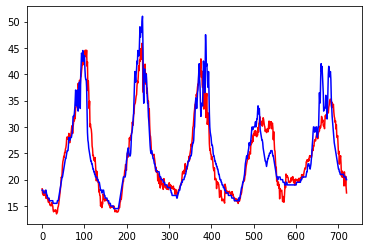

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(test_pred, color="r")
ax1.plot(test_y_parts, color="b") 
plt.show()

In [10]:
x_18parts = (x_18parts-train_x_parts_min)/train_x_parts_range
pred_need = model.predict(x_18parts)

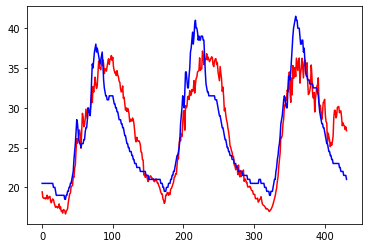

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(pred_need, color="r")
ax1.plot(y_18parts, color="b")
plt.show()

In [17]:
def return_model2():
    input_tens = tf.keras.Input(shape=(1))
    x = tf.keras.layers.Dense(100)(input_tens)
    x = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=input_tens, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=["mae"])
    print(model.summary())
    return model

In [18]:
model2 = return_model2()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
model2.fit(pred_need,y_18parts, epochs=1000, batch_size=16)

Train on 432 samples
Epoch 1/1000
432/432 [==============================] - 0s 383us/sample - loss: 274.3487 - mae: 15.0747
Epoch 2/1000
432/432 [==============================] - 0s 62us/sample - loss: 36.0443 - mae: 4.3272
Epoch 3/1000
432/432 [==============================] - 0s 55us/sample - loss: 19.8734 - mae: 3.8492
Epoch 4/1000
432/432 [==============================] - 0s 54us/sample - loss: 19.2135 - mae: 3.5820
Epoch 5/1000
432/432 [==============================] - 0s 50us/sample - loss: 19.3024 - mae: 3.5344
Epoch 6/1000
432/432 [==============================] - 0s 53us/sample - loss: 19.2348 - mae: 3.5454
Epoch 7/1000
432/432 [==============================] - 0s 50us/sample - loss: 19.2853 - mae: 3.6146
Epoch 8/1000
432/432 [==============================] - 0s 50us/sample - loss: 19.6147 - mae: 3.5054
Epoch 9/1000
432/432 [==============================] - 0s 53us/sample - loss: 19.4695 - mae: 3.6379
Epoch 10/1000
432/432 [==============================] - 0s 52us/sa

432/432 [==============================] - 0s 51us/sample - loss: 18.2099 - mae: 3.3950
Epoch 161/1000
432/432 [==============================] - 0s 51us/sample - loss: 18.5338 - mae: 3.4165
Epoch 162/1000
432/432 [==============================] - 0s 52us/sample - loss: 18.5939 - mae: 3.5116
Epoch 163/1000
432/432 [==============================] - 0s 56us/sample - loss: 18.0512 - mae: 3.4218
Epoch 164/1000
432/432 [==============================] - 0s 51us/sample - loss: 17.9135 - mae: 3.3358
Epoch 165/1000
432/432 [==============================] - 0s 52us/sample - loss: 18.9976 - mae: 3.5476
Epoch 166/1000
432/432 [==============================] - 0s 51us/sample - loss: 18.1683 - mae: 3.4199
Epoch 167/1000
432/432 [==============================] - 0s 51us/sample - loss: 18.1180 - mae: 3.4162
Epoch 168/1000
432/432 [==============================] - 0s 51us/sample - loss: 17.9562 - mae: 3.3848
Epoch 169/1000
432/432 [==============================] - 0s 53us/sample - loss: 18.1201

432/432 [==============================] - 0s 54us/sample - loss: 17.6612 - mae: 3.3532
Epoch 319/1000
432/432 [==============================] - 0s 56us/sample - loss: 17.5199 - mae: 3.3170
Epoch 320/1000
432/432 [==============================] - 0s 53us/sample - loss: 17.5973 - mae: 3.3486
Epoch 321/1000
432/432 [==============================] - 0s 52us/sample - loss: 17.6618 - mae: 3.3131
Epoch 322/1000
432/432 [==============================] - 0s 54us/sample - loss: 17.7387 - mae: 3.3080
Epoch 323/1000
432/432 [==============================] - 0s 56us/sample - loss: 17.8921 - mae: 3.3456
Epoch 324/1000
432/432 [==============================] - 0s 55us/sample - loss: 17.7620 - mae: 3.3972
Epoch 325/1000
432/432 [==============================] - 0s 53us/sample - loss: 17.8582 - mae: 3.3577
Epoch 326/1000
432/432 [==============================] - 0s 54us/sample - loss: 17.7851 - mae: 3.3109
Epoch 327/1000
432/432 [==============================] - 0s 53us/sample - loss: 17.6150

432/432 [==============================] - 0s 53us/sample - loss: 17.9863 - mae: 3.3854
Epoch 477/1000
432/432 [==============================] - 0s 53us/sample - loss: 17.8390 - mae: 3.3413
Epoch 478/1000
432/432 [==============================] - 0s 53us/sample - loss: 18.0399 - mae: 3.3399
Epoch 479/1000
432/432 [==============================] - 0s 53us/sample - loss: 17.5303 - mae: 3.2766
Epoch 480/1000
432/432 [==============================] - 0s 54us/sample - loss: 17.6302 - mae: 3.3123
Epoch 481/1000
432/432 [==============================] - 0s 52us/sample - loss: 17.5610 - mae: 3.3864
Epoch 482/1000
432/432 [==============================] - 0s 53us/sample - loss: 17.5237 - mae: 3.2724
Epoch 483/1000
432/432 [==============================] - 0s 52us/sample - loss: 17.7659 - mae: 3.3327
Epoch 484/1000
432/432 [==============================] - 0s 54us/sample - loss: 18.2359 - mae: 3.4231
Epoch 485/1000
432/432 [==============================] - 0s 55us/sample - loss: 17.8539

432/432 [==============================] - 0s 55us/sample - loss: 17.8247 - mae: 3.3440
Epoch 635/1000
432/432 [==============================] - 0s 51us/sample - loss: 17.6337 - mae: 3.3411
Epoch 636/1000
432/432 [==============================] - 0s 52us/sample - loss: 17.6311 - mae: 3.2894
Epoch 637/1000
432/432 [==============================] - 0s 50us/sample - loss: 17.8810 - mae: 3.3916
Epoch 638/1000
432/432 [==============================] - 0s 52us/sample - loss: 17.7451 - mae: 3.3276
Epoch 639/1000
432/432 [==============================] - 0s 53us/sample - loss: 17.7396 - mae: 3.2881
Epoch 640/1000
432/432 [==============================] - 0s 52us/sample - loss: 17.8098 - mae: 3.4529
Epoch 641/1000
432/432 [==============================] - 0s 50us/sample - loss: 17.7691 - mae: 3.2226
Epoch 642/1000
432/432 [==============================] - 0s 51us/sample - loss: 17.6351 - mae: 3.3096
Epoch 643/1000
432/432 [==============================] - 0s 51us/sample - loss: 17.6476

KeyboardInterrupt: 

In [ ]:
test_pred = model.predict(test_x_parts)
train_pred = model.predict(train_x_parts)
for idx in range(18):
    print("Y_"+str(idx)+" is ===")
    print("MSE(train) is {}".format(mean_squared_error(train_y_parts[:,idx], train_pred[:,idx])))
    print("MAE(train) is {}".format(mean_absolute_error(train_y_parts[:,idx], train_pred[:,idx])))
    print("MSE(test) is {}".format(mean_squared_error(test_y_parts[:,idx], test_pred[:,idx])))
    print("MAE(test) is {}".format(mean_absolute_error(test_y_parts[:,idx], test_pred[:,idx])))